In [1]:
!pip install skforecast


# 1. LIBRARIES AND SETUP

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose



# 2. DATA LOADING AND PREPARATION


In [3]:

print("DATA LOADING AND PREPARATION")

# Loading the two main datasets (2010-2025)
URL_GENERAL = 'https://storage.dosm.gov.my/labour/lfs_month.parquet' # general raw montly labour force data
URL_SA = 'https://storage.dosm.gov.my/labour/lfs_month_sa.parquet' #seasonally adjusted labour force data

# Load general unemployment data
df_general = pd.read_parquet(URL_GENERAL)
df_general['date'] = pd.to_datetime(df_general['date'])
df_general = df_general.set_index('date')
df_general = df_general.asfreq('MS')

# Load seasonally adjusted data
df_sa = pd.read_parquet(URL_SA)
df_sa['date'] = pd.to_datetime(df_sa['date'])
df_sa = df_sa.set_index('date')
df_sa = df_sa.asfreq('MS')

print(f"General data shape: {df_general.shape}")
print(f"Seasonally adjusted data shape: {df_sa.shape}")
print(f"Date range: {df_general.index.min()} to {df_general.index.max()}")

# extracting the target variable
unemployment_general = df_general['u_rate'].copy()
unemployment_sa = df_sa['u_rate'].copy()

unemployment_general = unemployment_general.asfreq('MS')
unemployment_sa = unemployment_sa.asfreq('MS')

print(f"Unemployment rate series length: {len(unemployment_general)} months")

DATA LOADING AND PREPARATION
General data shape: (183, 7)
Seasonally adjusted data shape: (183, 5)
Date range: 2010-01-01 00:00:00 to 2025-03-01 00:00:00
Unemployment rate series length: 183 months


## DATA QUALITY CHECK AND MISSING VALUE HANDLING

In [4]:
print("\n" + "="*80)
print("DATA QUALITY CHECK AND CLEANING")
print("="*80)

def check_and_clean_data(series, name):
    """Check data quality and handle missing values"""
    print(f"\n{'-'*50}")
    print(f"Data Quality Check: {name}")
    print(f"{'-'*50}")

    print(f"Shape: {series.shape}")
    print(f"Missing values: {series.isna().sum()}")
    print(f"Data type: {series.dtype}")
    print(f"Date range: {series.index.min()} to {series.index.max()}")

    if series.isna().sum() > 0:
        print(f"Found {series.isna().sum()} missing values")

        # Check skewness for imputation method
        skewness = series.skew()
        print(f"Skewness: {skewness:.4f}")

        # Use interpolation for time series data
        series_clean = series.interpolate(method='linear', limit_direction='both')

        # Filling any remaining NAs with median
        if series_clean.isna().sum() > 0:
            fill_value = series.median()
            series_clean = series_clean.fillna(fill_value)
            print(f"Filled remaining NAs with median: {fill_value:.4f}")

        print(f"Missing values after cleaning: {series_clean.isna().sum()}")
        return series_clean
    else:
        print("No missing values found")
        return series

# Cleaning both unemployment series
unemployment_general = check_and_clean_data(unemployment_general, "General Unemployment Rate")
unemployment_sa = check_and_clean_data(unemployment_sa, "Seasonally Adjusted Unemployment Rate")

# Verifying data integrity
print(f"\n Data cleaning completed:")
print(f"General unemployment: {len(unemployment_general)} data points, {unemployment_general.isna().sum()} missing")
print(f"SA unemployment: {len(unemployment_sa)} data points, {unemployment_sa.isna().sum()} missing")


DATA QUALITY CHECK AND CLEANING

--------------------------------------------------
Data Quality Check: General Unemployment Rate
--------------------------------------------------
Shape: (183,)
Missing values: 0
Data type: float64
Date range: 2010-01-01 00:00:00 to 2025-03-01 00:00:00
No missing values found

--------------------------------------------------
Data Quality Check: Seasonally Adjusted Unemployment Rate
--------------------------------------------------
Shape: (183,)
Missing values: 0
Data type: float64
Date range: 2010-01-01 00:00:00 to 2025-03-01 00:00:00
No missing values found

 Data cleaning completed:
General unemployment: 183 data points, 0 missing
SA unemployment: 183 data points, 0 missing


# 3. TRAIN-VALIDATION-TEST SPLITS

TRAIN-VALIDATION-TEST SPLITS
Train period: 2010-01-01 00:00:00 to 2022-12-01 00:00:00 (n=156)
Validation period: 2023-02-01 00:00:00 to 2023-12-01 00:00:00 (n=11)
Test period: 2024-02-01 00:00:00 to 2025-03-01 00:00:00 (n=14)


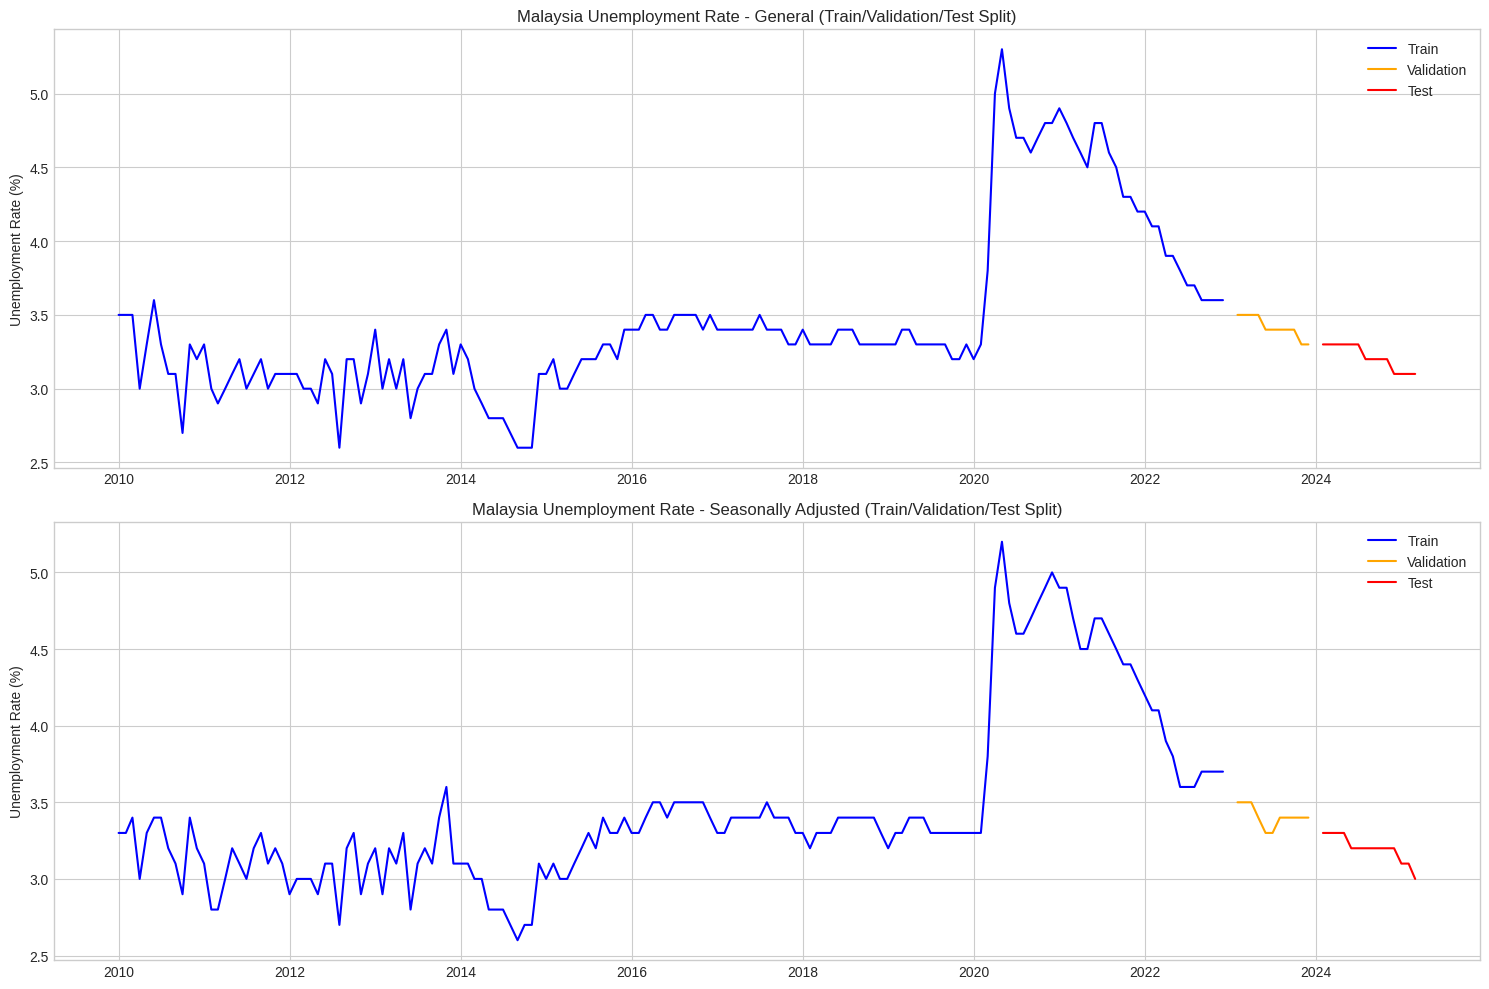

In [5]:
print("TRAIN-VALIDATION-TEST SPLITS")

# Defining split dates
end_train = '2022-12-31'  # Train on 2010-2022 (13 years)
end_val = '2023-12-31'    # Validation on 2022-2023 (1 year)

# Creating splits
train_general = unemployment_general.loc[:end_train].asfreq('MS')
val_general = unemployment_general.loc[end_train:end_val].iloc[1:].asfreq('MS')
test_general = unemployment_general.loc[end_val:].iloc[1:].asfreq('MS')

train_sa = unemployment_sa.loc[:end_train].asfreq('MS')
val_sa = unemployment_sa.loc[end_train:end_val].iloc[1:].asfreq('MS')
test_sa = unemployment_sa.loc[end_val:].iloc[1:].asfreq('MS')

print(f"Train period: {train_general.index.min()} to {train_general.index.max()} (n={len(train_general)})")
print(f"Validation period: {val_general.index.min()} to {val_general.index.max()} (n={len(val_general)})")
print(f"Test period: {test_general.index.min()} to {test_general.index.max()} (n={len(test_general)})")

# Plotting the splits
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# General unemployment plot
axes[0].plot(train_general.index, train_general.values, label='Train', color='blue')
axes[0].plot(val_general.index, val_general.values, label='Validation', color='orange')
axes[0].plot(test_general.index, test_general.values, label='Test', color='red')
axes[0].set_title('Malaysia Unemployment Rate - General (Train/Validation/Test Split)')
axes[0].set_ylabel('Unemployment Rate (%)')
axes[0].legend()
axes[0].grid(True)

# Seasonally adjusted unemployment plot
axes[1].plot(train_sa.index, train_sa.values, label='Train', color='blue')
axes[1].plot(val_sa.index, val_sa.values, label='Validation', color='orange')
axes[1].plot(test_sa.index, test_sa.values, label='Test', color='red')
axes[1].set_title('Malaysia Unemployment Rate - Seasonally Adjusted (Train/Validation/Test Split)')
axes[1].set_ylabel('Unemployment Rate (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 4. STATIONARITY ANALYSIS

In [6]:
print("STATIONARITY ANALYSIS")

def test_stationarity(series, title):
    """Test stationarity using ADF and KPSS tests"""
    print(f"\n{'-'*60}")
    print(f"Stationarity Tests: {title}")
    print(f"{'-'*60}")

    # ADF Test (Augmented Dickey-Fuller test)
    adf_result = adfuller(series.dropna())
    print(f"ADF Test:")
    print(f"  Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values: {adf_result[4]}")

    # KPSS Test ( Kwiatkowski-Phillips-Schmidt-Shin)
    kpss_result = kpss(series.dropna())
    print(f"KPSS Test:")
    print(f"  Statistic: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")

    # Conclusions
    adf_stationary = adf_result[1] < 0.05
    kpss_stationary = kpss_result[1] > 0.05

    print(f"Conclusions:")
    print(f"  ADF: {'Stationary' if adf_stationary else 'Non-stationary'}")
    print(f"  KPSS: {'Stationary' if kpss_stationary else 'Non-stationary'}")

    return adf_stationary and kpss_stationary

# Test original series
is_stationary_general = test_stationarity(train_general, "General Unemployment Rate (Original)")
is_stationary_sa = test_stationarity(train_sa, "Seasonally Adjusted Unemployment Rate (Original)")

# Test differenced series
train_general_diff = train_general.diff().dropna()
train_sa_diff = train_sa.diff().dropna()

test_stationarity(train_general_diff, "General Unemployment Rate (First Difference)")
test_stationarity(train_sa_diff, "Seasonally Adjusted Unemployment Rate (First Difference)")

STATIONARITY ANALYSIS

------------------------------------------------------------
Stationarity Tests: General Unemployment Rate (Original)
------------------------------------------------------------
ADF Test:
  Statistic: -2.1790
  p-value: 0.2139
  Critical Values: {'1%': np.float64(-3.4732590518613002), '5%': np.float64(-2.880374082105334), '10%': np.float64(-2.5768120811654525)}
KPSS Test:
  Statistic: 1.0271
  p-value: 0.0100
Conclusions:
  ADF: Non-stationary
  KPSS: Non-stationary

------------------------------------------------------------
Stationarity Tests: Seasonally Adjusted Unemployment Rate (Original)
------------------------------------------------------------
ADF Test:
  Statistic: -2.0568
  p-value: 0.2622
  Critical Values: {'1%': np.float64(-3.4732590518613002), '5%': np.float64(-2.880374082105334), '10%': np.float64(-2.5768120811654525)}
KPSS Test:
  Statistic: 1.0545
  p-value: 0.0100
Conclusions:
  ADF: Non-stationary
  KPSS: Non-stationary

-------------------

<ipython-input-6-d0e8a2ac086d>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())
<ipython-input-6-d0e8a2ac086d>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())
<ipython-input-6-d0e8a2ac086d>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna())
<ipython-input-6-d0e8a2ac086d>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna())


np.True_

# 5. ACF/PACF ANALYSIS

ACF/PACF ANALYSIS


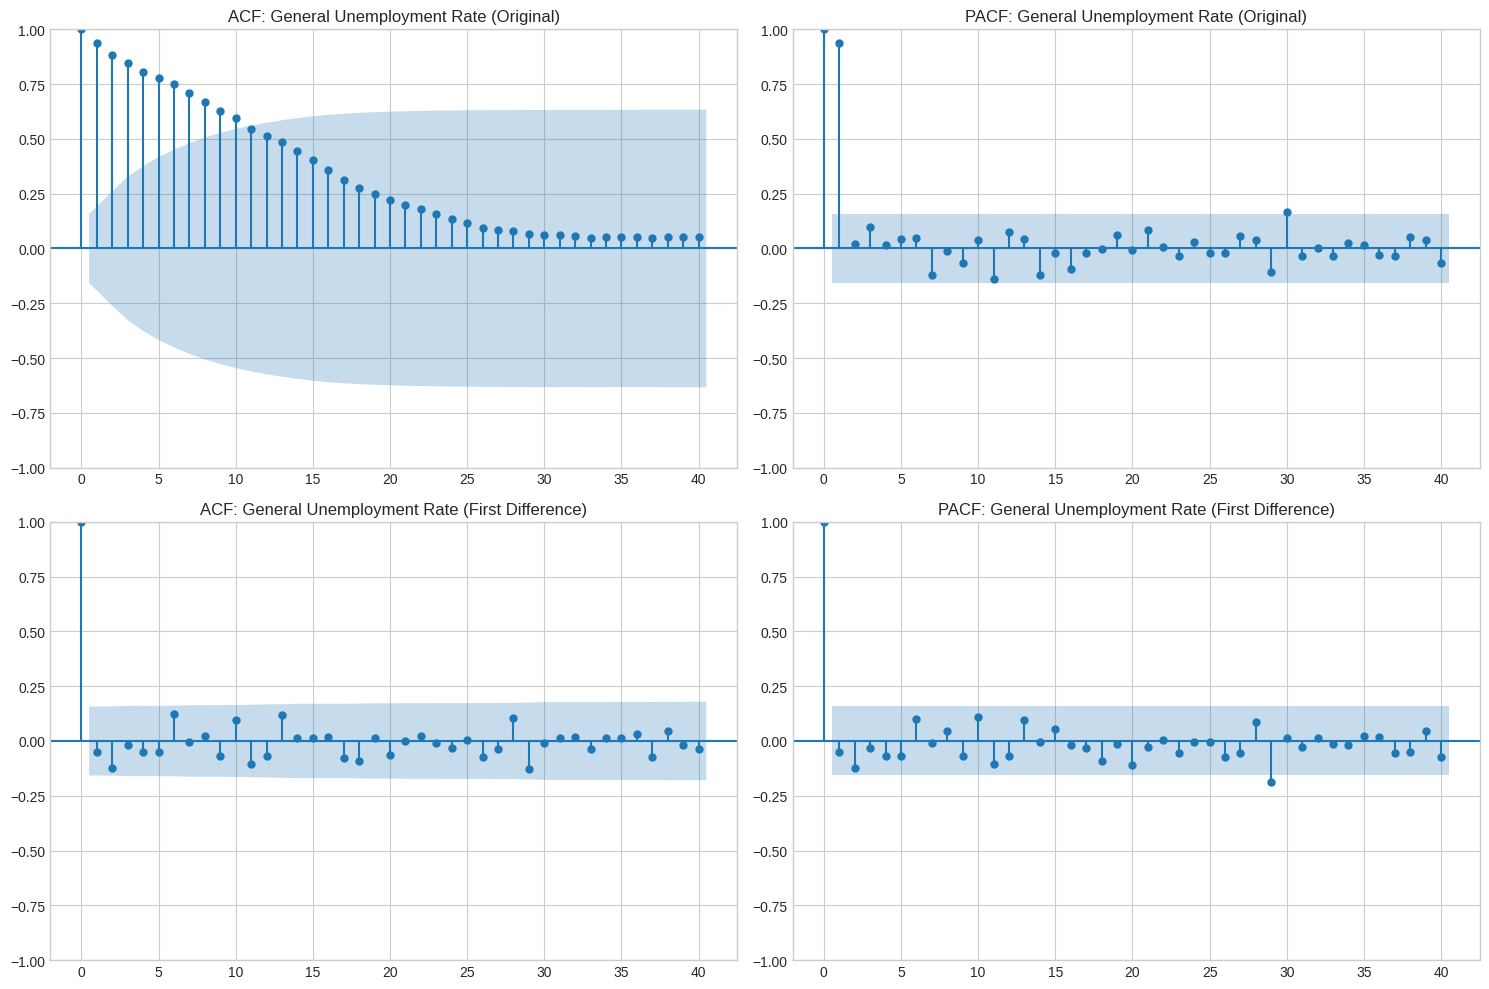

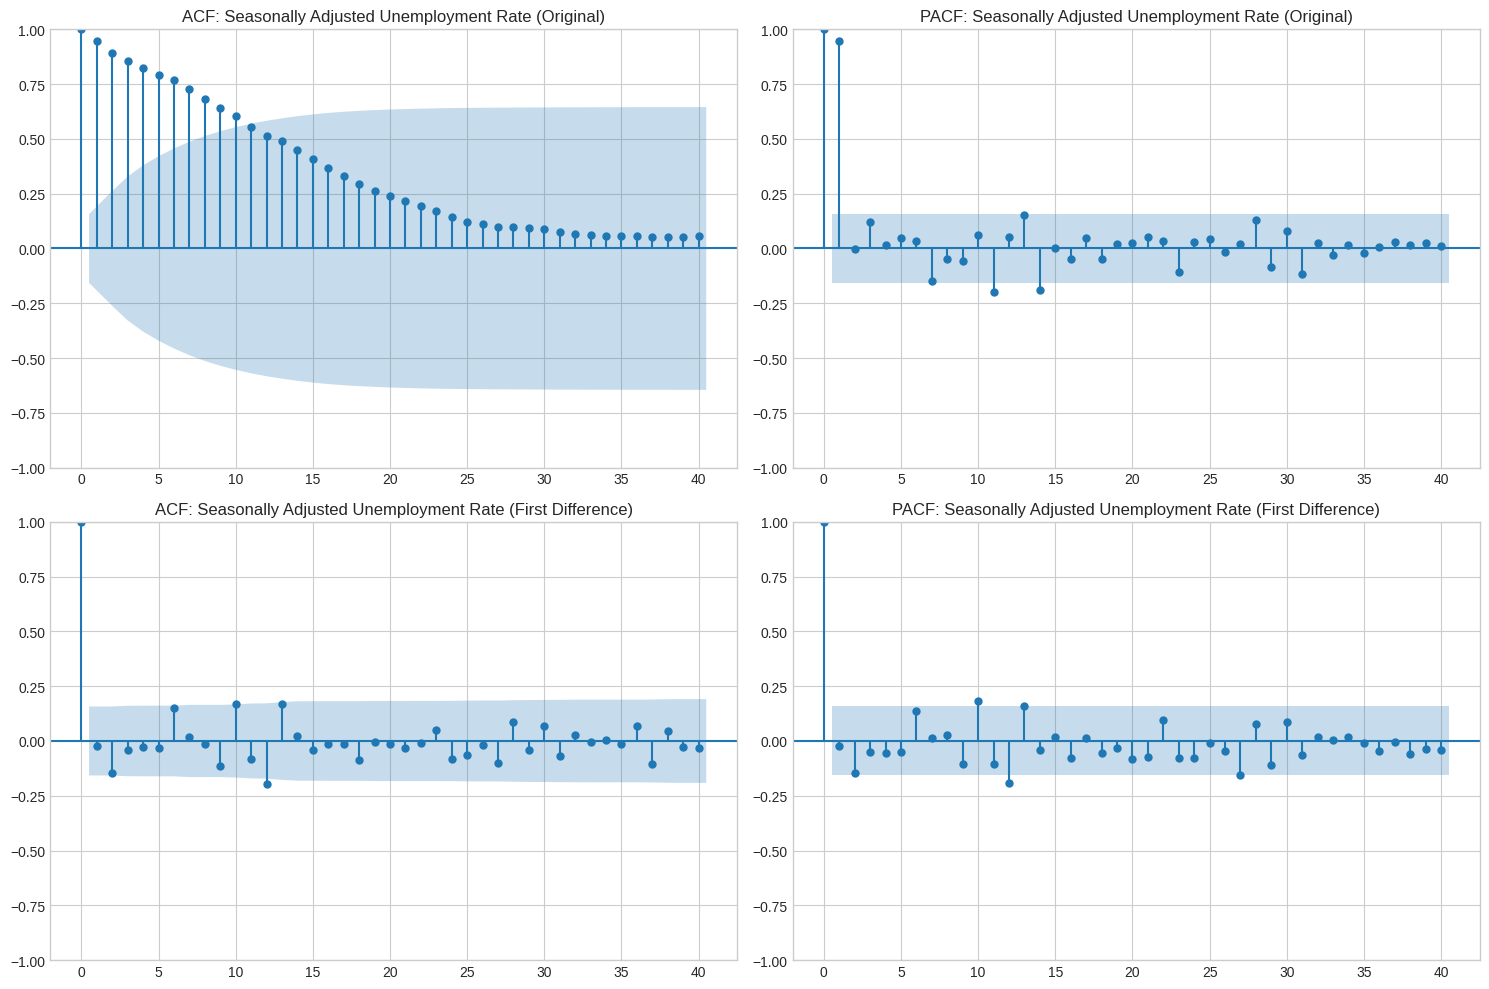

In [7]:
print("ACF/PACF ANALYSIS")

def plot_acf_pacf_analysis(series, title, max_lags=40):
    """Plot ACF and PACF for both original and differenced series"""

    series_diff = series.diff().dropna()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # ACF original
    plot_acf(series.dropna(), ax=axes[0,0], lags=max_lags, alpha=0.05)
    axes[0,0].set_title(f'ACF: {title} (Original)')

    # PACF original
    plot_pacf(series.dropna(), ax=axes[0,1], lags=max_lags, alpha=0.05)
    axes[0,1].set_title(f'PACF: {title} (Original)')

    # ACF differenced
    plot_acf(series_diff.dropna(), ax=axes[1,0], lags=max_lags, alpha=0.05)
    axes[1,0].set_title(f'ACF: {title} (First Difference)')

    # PACF differenced
    plot_pacf(series_diff.dropna(), ax=axes[1,1], lags=max_lags, alpha=0.05)
    axes[1,1].set_title(f'PACF: {title} (First Difference)')

    plt.tight_layout()
    plt.show()

# plotting both series
plot_acf_pacf_analysis(train_general, "General Unemployment Rate")
plot_acf_pacf_analysis(train_sa, "Seasonally Adjusted Unemployment Rate")

# 6. SEASONAL DECOMPOSITION

SEASONAL DECOMPOSITION


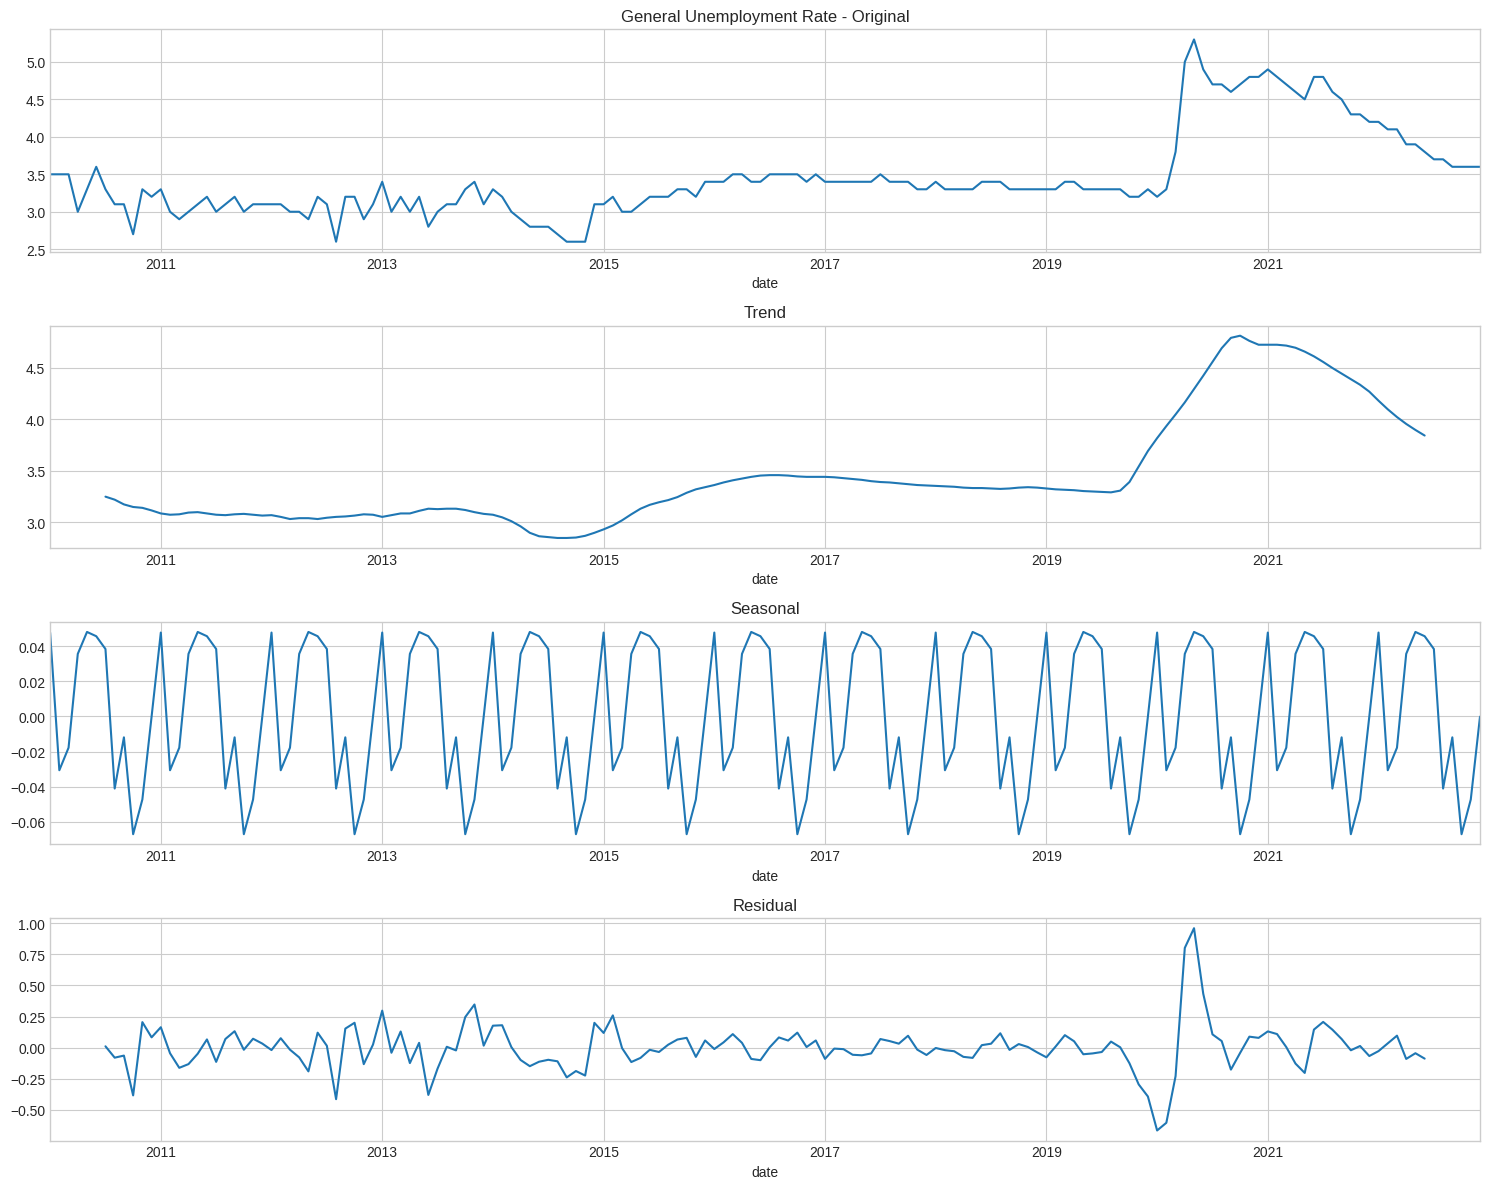

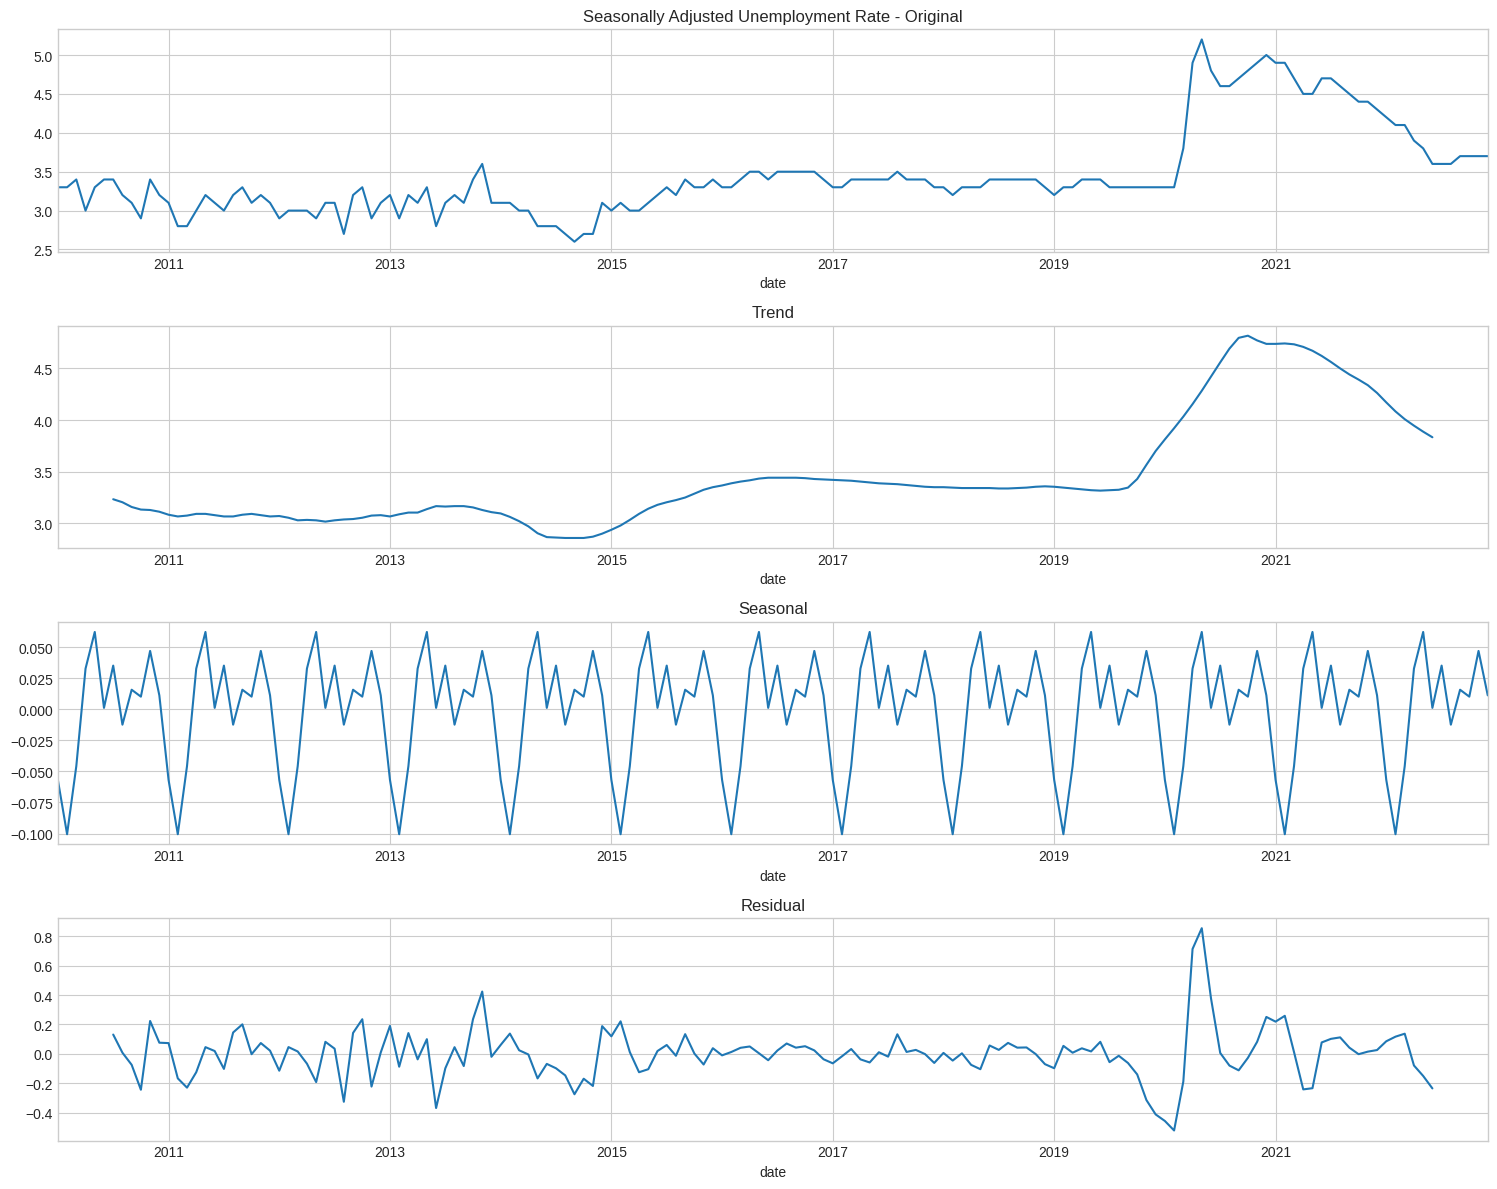

In [8]:
print("SEASONAL DECOMPOSITION")

def plot_seasonal_decomposition(series, title):
    """Plot seasonal decomposition"""
    decomposition = seasonal_decompose(series.dropna(), model='additive', period=12)

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    decomposition.observed.plot(ax=axes[0], title=f'{title} - Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')

    plt.tight_layout()
    plt.show()

    return decomposition

# Decompose both series
decomp_general = plot_seasonal_decomposition(train_general, "General Unemployment Rate")
decomp_sa = plot_seasonal_decomposition(train_sa, "Seasonally Adjusted Unemployment Rate")

# 7. SARIMA MODEL SELECTION WITH MISSING VALUE HANDLING

In [9]:
print("SARIMA MODEL SELECTION WITH GRID SEARCH")

# define parameter search space to get the (p,q,r) values for arima
param_grid = {
    'order': [
        (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1),  # Non-seasonal parameters
        (0, 1, 2), (2, 1, 2)  # Additional parameters based on ACF/PACF
    ],
    'seasonal_order': [
        (0, 1, 1, 12), (1, 1, 1, 12), (2, 1, 1, 12),  # Seasonal parameters with 12 denoting for year
        (1, 1, 2, 12), (2, 1, 2, 12)  # EDA shows strong seasonality
    ],
    'trend': [None, 'c']  # No trend vs constant trend
}

print(f"Grid search will test {len(param_grid['order']) * len(param_grid['seasonal_order']) * len(param_grid['trend'])} combinations")

def handle_missing_values(series, method='auto'):
    """
    Handle missing values using appropriate imputation method based on skewness
    """
    print(f"\nHandling missing values for series:")
    print(f"Original length: {len(series)}")
    print(f"Missing values: {series.isna().sum()}")

    if series.isna().sum() == 0:
        print("No missing values found")
        return series

    # Calculate skewness to determine imputation method - non-skewed data I use Mean while skewed data I use Median
    skewness = series.skew()
    print(f"Skewness: {skewness:.4f}")

    if method == 'auto':
        if abs(skewness) < 0.5:  # normal distribution
            impute_value = series.mean()
            method_used = 'mean'
        else:  # Skewed distribution
            impute_value = series.median()
            method_used = 'median'
    elif method == 'mean':
        impute_value = series.mean()
        method_used = 'mean'
    elif method == 'median':
        impute_value = series.median()
        method_used = 'median'
    elif method == 'interpolate':
        # Linear interpolation for time series
        series_filled = series.interpolate(method='linear', limit_direction='both')
        print(f"Used linear interpolation")
        print(f"Remaining missing values after interpolation: {series_filled.isna().sum()}")

        # Fill any remaining missing values with median
        if series_filled.isna().sum() > 0:
            series_filled = series_filled.fillna(series.median())
            print(f"Filled remaining NaNs with median: {series.median():.4f}")

        return series_filled

    # Fill missing values
    series_filled = series.fillna(impute_value)
    print(f"Used {method_used} imputation: {impute_value:.4f}")
    print(f"Missing values after imputation: {series_filled.isna().sum()}")

    return series_filled

def prepare_data_for_grid_search_with_imputation(train_data, val_data):
    """Properly combine and clean data for grid search"""
    print(f"\nPreparing data for grid search...")

    # Ensure data uses the monthly frequency
    train_clean = train_data.asfreq('MS')
    val_clean = val_data.asfreq('MS')

    # Combining with proper indexing
    combined = pd.concat([train_clean, val_clean])
    combined = combined.asfreq('MS')

    print(f"Combined data shape: {combined.shape}")
    print(f"Date range: {combined.index.min()} to {combined.index.max()}")

    # Handle missing values using interpolation for time series
    combined_clean = handle_missing_values(combined, method='interpolate')

    return combined_clean

# Prepare data for grid search with missing value handling
full_data_general = prepare_data_for_grid_search_with_imputation(train_general, val_general)
full_data_sa = prepare_data_for_grid_search_with_imputation(train_sa, val_sa)

print(f"\nFinal data for grid search:")
print(f"General - Length: {len(full_data_general)}, Missing: {full_data_general.isna().sum()}")
print(f"SA - Length: {len(full_data_sa)}, Missing: {full_data_sa.isna().sum()}")

# Setting up time series cross-validation
cv = TimeSeriesFold(
    steps=6,  # 6-month ahead forecasts
    initial_train_size=len(train_general),
    refit=True,
    fixed_train_size=False
)

def perform_grid_search_with_validation(data_series, series_name):
    """Perform grid search for SARIMA parameters with proper validation"""
    print(f"\nPerforming grid search for {series_name}...")
    print(f"Data validation:")
    print(f"  Length: {len(data_series)}")
    print(f"  Missing values: {data_series.isna().sum()}")
    print(f"  Data type: {type(data_series)}")
    print(f"  Index type: {type(data_series.index)}")
    print(f"  Frequency: {data_series.index.freq}")

    # Final validation
    if data_series.isna().sum() > 0:
        print(" Still have missing values")
        data_series = data_series.fillna(method='ffill').fillna(method='bfill')
        print(f"Missing values after final cleanup: {data_series.isna().sum()}")

    forecaster = ForecasterSarimax(
        regressor=Sarimax(order=(1, 1, 1), maxiter=500)
    )

    try:
        results = grid_search_sarimax(
            forecaster=forecaster,
            y=data_series,
            cv=cv,
            param_grid=param_grid,
            metric='mean_absolute_error',
            return_best=False,
            suppress_warnings_fit=True,
            verbose=False
        )
        return results
    except Exception as e:
        print(f"Grid search failed: {e}")
        print("Trying with smaller parameter grid...")

        param_grid_small = {
            'order': [(1, 1, 1), (0, 1, 1), (2, 1, 1)],
            'seasonal_order': [(1, 1, 1, 12), (0, 1, 1, 12)],
            'trend': [None, 'c']
        }

        results = grid_search_sarimax(
            forecaster=forecaster,
            y=data_series,
            cv=cv,
            param_grid=param_grid_small,
            metric='mean_absolute_error',
            return_best=False,
            suppress_warnings_fit=True,
            verbose=False
        )
        return results

# Performing grid search for both series
print("Grid Search for General Unemployment Rate:")
results_general = perform_grid_search_with_validation(full_data_general, "General")

print("\nGrid Search for Seasonally Adjusted Unemployment Rate:")
results_sa = perform_grid_search_with_validation(full_data_sa, "Seasonally Adjusted")

print("Grid search completed successfully!")

SARIMA MODEL SELECTION WITH GRID SEARCH
Grid search will test 60 combinations

Preparing data for grid search...
Combined data shape: (168,)
Date range: 2010-01-01 00:00:00 to 2023-12-01 00:00:00

Handling missing values for series:
Original length: 168
Missing values: 1
Skewness: 1.4473
Used linear interpolation
Remaining missing values after interpolation: 0

Preparing data for grid search...
Combined data shape: (168,)
Date range: 2010-01-01 00:00:00 to 2023-12-01 00:00:00

Handling missing values for series:
Original length: 168
Missing values: 1
Skewness: 1.4687
Used linear interpolation
Remaining missing values after interpolation: 0

Final data for grid search:
General - Length: 168, Missing: 0
SA - Length: 168, Missing: 0
Grid Search for General Unemployment Rate:

Performing grid search for General...
Data validation:
  Length: 168
  Missing values: 0
  Data type: <class 'pandas.core.series.Series'>
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  Frequenc

params grid:   0%|          | 0/60 [00:00<?, ?it/s]


Grid Search for Seasonally Adjusted Unemployment Rate:

Performing grid search for Seasonally Adjusted...
Data validation:
  Length: 168
  Missing values: 0
  Data type: <class 'pandas.core.series.Series'>
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  Frequency: <MonthBegin>
Number of models compared: 60.


params grid:   0%|          | 0/60 [00:00<?, ?it/s]

Grid search completed successfully!


# 8. DISPLAY BEST RESULTS

In [10]:
print("BEST SARIMA PARAMETERS")

print("\nTop 5 models for General Unemployment Rate:")
print(results_general.head())

print("\nTop 5 models for Seasonally Adjusted Unemployment Rate:")
print(results_sa.head())

# Get best parameters
best_params_general = results_general.iloc[0]
best_params_sa = results_sa.iloc[0]

print(f"\nBest parameters for General: {best_params_general['params']}")
print(f"Best MAE for General: {best_params_general['mean_absolute_error']:.4f}")

print(f"\nBest parameters for SA: {best_params_sa['params']}")
print(f"Best MAE for SA: {best_params_sa['mean_absolute_error']:.4f}")

BEST SARIMA PARAMETERS

Top 5 models for General Unemployment Rate:
                                              params  mean_absolute_error  \
0  {'order': (0, 1, 2), 'seasonal_order': (0, 1, ...             0.109202   
1  {'order': (2, 1, 1), 'seasonal_order': (0, 1, ...             0.109270   
2  {'order': (0, 1, 1), 'seasonal_order': (0, 1, ...             0.109721   
3  {'order': (2, 1, 1), 'seasonal_order': (0, 1, ...             0.109831   
4  {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...             0.110035   

       order seasonal_order trend  
0  (0, 1, 2)  (0, 1, 1, 12)  None  
1  (2, 1, 1)  (0, 1, 1, 12)  None  
2  (0, 1, 1)  (0, 1, 1, 12)  None  
3  (2, 1, 1)  (0, 1, 1, 12)     c  
4  (1, 1, 0)  (0, 1, 1, 12)  None  

Top 5 models for Seasonally Adjusted Unemployment Rate:
                                              params  mean_absolute_error  \
0  {'order': (0, 1, 2), 'seasonal_order': (0, 1, ...             0.129298   
1  {'order': (2, 1, 2), 'seasonal_order': 

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


# 9. TRAIN BEST MODELS

In [11]:
print("TRAINING BEST SARIMA MODELS")

# Extracting parameters
def extract_sarima_params(params_row):
    """Extract SARIMA parameters from grid search results - handles both dict and string"""
    if isinstance(params_row, str):
        param_dict = eval(params_row)
    elif isinstance(params_row, dict):
        param_dict = params_row
    else:
        param_dict = params_row

    return {
        'order': param_dict['order'],
        'seasonal_order': param_dict['seasonal_order'],
        'trend': param_dict.get('trend', None)
    }

# Getting best parameters
try:
    params_general = extract_sarima_params(best_params_general['params'])
    params_sa = extract_sarima_params(best_params_sa['params'])
except:
    params_dict_general = dict(results_general.iloc[0])
    params_dict_sa = dict(results_sa.iloc[0])

    # Extracting from the dictionary
    if isinstance(params_dict_general['params'], str):
        params_general = extract_sarima_params(eval(params_dict_general['params']))
        params_sa = extract_sarima_params(eval(params_dict_sa['params']))
    else:
        params_general = extract_sarima_params(params_dict_general['params'])
        params_sa = extract_sarima_params(params_dict_sa['params'])

print(f"Training General Unemployment SARIMA{params_general['order']}x{params_general['seasonal_order']}")
print(f"Training SA Unemployment SARIMA{params_sa['order']}x{params_sa['seasonal_order']}")

# Training final models
forecaster_general = ForecasterSarimax(
    regressor=Sarimax(
        order=params_general['order'],
        seasonal_order=params_general['seasonal_order'],
        trend=params_general['trend'],
        maxiter=500
    )
)
forecaster_general.fit(y=train_general, suppress_warnings=True)

forecaster_sa = ForecasterSarimax(
    regressor=Sarimax(
        order=params_sa['order'],
        seasonal_order=params_sa['seasonal_order'],
        trend=params_sa['trend'],
        maxiter=500
    )
)
forecaster_sa.fit(y=train_sa, suppress_warnings=True)

print("Final SARIMA models trained successfully")

# outputting the parameters that were selected
print(f"\nSelected Parameters:")
print(f"General: SARIMA{params_general['order']}x{params_general['seasonal_order']}")
print(f"SA: SARIMA{params_sa['order']}x{params_sa['seasonal_order']}")

TRAINING BEST SARIMA MODELS
Training General Unemployment SARIMA(0, 1, 2)x(0, 1, 1, 12)
Training SA Unemployment SARIMA(0, 1, 2)x(0, 1, 1, 12)
Final SARIMA models trained successfully

Selected Parameters:
General: SARIMA(0, 1, 2)x(0, 1, 1, 12)
SA: SARIMA(0, 1, 2)x(0, 1, 1, 12)


# 10. GENERATE FORECASTS

In [12]:
print("GENERATING FORECASTS")

# Generating forecasts for validation period
print("Generating validation forecasts...")
forecast_general_val = forecaster_general.predict(steps=len(val_general))
forecast_sa_val = forecaster_sa.predict(steps=len(val_sa))

# For test forecasts, I use validation data to do retraining
print("Retraining models with validation data for test forecasts...")

# combining train and validation data with missing value handling
def combine_and_clean_data(train_data, val_data, name):
    """Combine train and validation data and handle any missing values"""
    print(f"\nCombining data for {name}:")
    print(f"Train data: {len(train_data)} obs, {train_data.isna().sum()} missing")
    print(f"Val data: {len(val_data)} obs, {val_data.isna().sum()} missing")

    # Combining with proper monthly frequency
    combined = pd.concat([train_data, val_data]).asfreq('MS')
    print(f"Combined: {len(combined)} obs, {combined.isna().sum()} missing")

    # Handling any missing values
    if combined.isna().sum() > 0:
        print(f"Fixing {combined.isna().sum()} missing values...")
        # Using interpolation first
        combined = combined.interpolate(method='linear', limit_direction='both')
        # Fill any remaining with forward/backward fill
        combined = combined.fillna(method='ffill').fillna(method='bfill')
        print(f"After cleaning: {combined.isna().sum()} missing values")

    return combined

# Combining and cleaning the data
train_val_general = combine_and_clean_data(train_general, val_general, "General")
train_val_sa = combine_and_clean_data(train_sa, val_sa, "SA")

# Retraining models with cleaned data
forecaster_general_updated = ForecasterSarimax(
    regressor=Sarimax(
        order=params_general['order'],
        seasonal_order=params_general['seasonal_order'],
        trend=params_general['trend'],
        maxiter=500
    )
)
forecaster_general_updated.fit(y=train_val_general, suppress_warnings=True)

forecaster_sa_updated = ForecasterSarimax(
    regressor=Sarimax(
        order=params_sa['order'],
        seasonal_order=params_sa['seasonal_order'],
        trend=params_sa['trend'],
        maxiter=500
    )
)
forecaster_sa_updated.fit(y=train_val_sa, suppress_warnings=True)

# Generating test forecasts
print("Generating test forecasts...")
forecast_general_test = forecaster_general_updated.predict(steps=len(test_general))
forecast_sa_test = forecaster_sa_updated.predict(steps=len(test_sa))

print("All forecasts generated successfully")

# Outputting forecast summaries
print(f"\n Forecast Summary:")
print(f"Validation forecasts: {len(forecast_general_val)} months")
print(f"Test forecasts: {len(forecast_general_test)} months")
print(f"Validation period: {forecast_general_val.index[0]} to {forecast_general_val.index[-1]}")
print(f"Test period: {forecast_general_test.index[0]} to {forecast_general_test.index[-1]}")

GENERATING FORECASTS
Generating validation forecasts...
Retraining models with validation data for test forecasts...

Combining data for General:
Train data: 156 obs, 0 missing
Val data: 11 obs, 0 missing
Combined: 168 obs, 1 missing
Fixing 1 missing values...
After cleaning: 0 missing values

Combining data for SA:
Train data: 156 obs, 0 missing
Val data: 11 obs, 0 missing
Combined: 168 obs, 1 missing
Fixing 1 missing values...
After cleaning: 0 missing values


<ipython-input-12-988fee40c87a>:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined = combined.fillna(method='ffill').fillna(method='bfill')


Generating test forecasts...
All forecasts generated successfully

 Forecast Summary:
Validation forecasts: 11 months
Test forecasts: 14 months
Validation period: 2023-01-01 00:00:00 to 2023-11-01 00:00:00
Test period: 2024-01-01 00:00:00 to 2025-02-01 00:00:00


# 11. MODEL EVALUATION METRICS

In [13]:
print("MODEL EVALUATION METRICS")

from sklearn.metrics import mean_absolute_error, mean_squared_error

# For evaluation, I am using Mean Absolute Error, Root Mean Square Error and Mean Absolute Percentage Error
def calculate_metrics(actual, predicted, series_name, period):
    """Calculate comprehensive evaluation metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    print(f"\n{series_name} - {period} Period:")
    print(f"  MAE:  {mae:.4f}") # Mean Absolute Error
    print(f"  RMSE: {rmse:.4f}") # Root Mean Square Error
    print(f"  MAPE: {mape:.2f}%") # Mean Absolute Percentage Error

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Calculating metrics
metrics_general_val = calculate_metrics(val_general.values, forecast_general_val.values,
                                       "General Unemployment", "Validation")
metrics_sa_val = calculate_metrics(val_sa.values, forecast_sa_val.values,
                                  "Seasonally Adjusted Unemployment", "Validation")

metrics_general_test = calculate_metrics(test_general.values, forecast_general_test.values,
                                        "General Unemployment", "Test")
metrics_sa_test = calculate_metrics(test_sa.values, forecast_sa_test.values,
                                   "Seasonally Adjusted Unemployment", "Test")

MODEL EVALUATION METRICS

General Unemployment - Validation Period:
  MAE:  0.2137
  RMSE: 0.2253
  MAPE: 6.29%

Seasonally Adjusted Unemployment - Validation Period:
  MAE:  0.2844
  RMSE: 0.3041
  MAPE: 8.40%

General Unemployment - Test Period:
  MAE:  0.1014
  RMSE: 0.1200
  MAPE: 3.20%

Seasonally Adjusted Unemployment - Test Period:
  MAE:  0.1703
  RMSE: 0.1921
  MAPE: 5.39%


# 12. FINAL VISUALIZATION

VISUALIZATION OF FORECASTING RESULTS


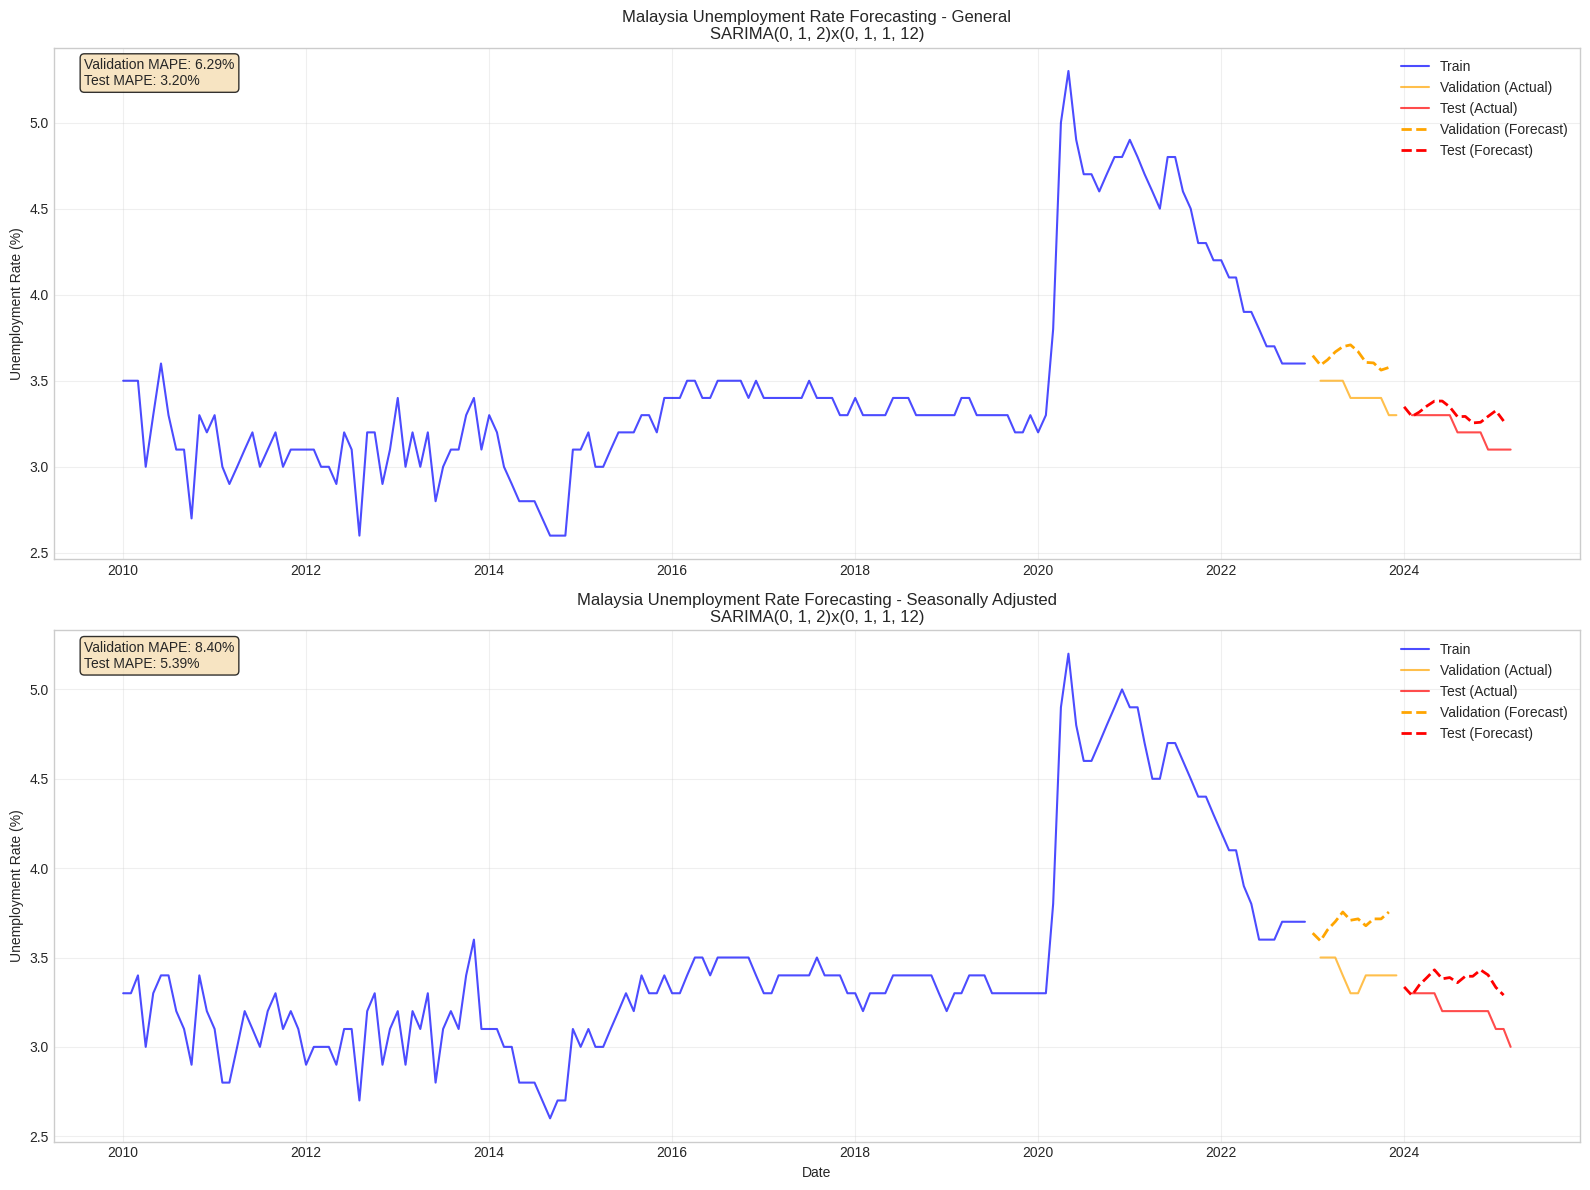

In [14]:
print("VISUALIZATION OF FORECASTING RESULTS")

# Creating forecast visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# General unemployment forecasts
axes[0].plot(train_general.index, train_general.values, label='Train', color='blue', alpha=0.7)
axes[0].plot(val_general.index, val_general.values, label='Validation (Actual)', color='orange', alpha=0.7)
axes[0].plot(test_general.index, test_general.values, label='Test (Actual)', color='red', alpha=0.7)
axes[0].plot(forecast_general_val.index, forecast_general_val.values,
            label='Validation (Forecast)', linestyle='--', color='orange', linewidth=2)
axes[0].plot(forecast_general_test.index, forecast_general_test.values,
            label='Test (Forecast)', linestyle='--', color='red', linewidth=2)

axes[0].set_title(f'Malaysia Unemployment Rate Forecasting - General\nSARIMA{params_general["order"]}x{params_general["seasonal_order"]}')
axes[0].set_ylabel('Unemployment Rate (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Adding metrics
axes[0].text(0.02, 0.98, f'Validation MAPE: {metrics_general_val["MAPE"]:.2f}%\nTest MAPE: {metrics_general_test["MAPE"]:.2f}%',
            transform=axes[0].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Seasonally adjusted unemployment forecasts
axes[1].plot(train_sa.index, train_sa.values, label='Train', color='blue', alpha=0.7)
axes[1].plot(val_sa.index, val_sa.values, label='Validation (Actual)', color='orange', alpha=0.7)
axes[1].plot(test_sa.index, test_sa.values, label='Test (Actual)', color='red', alpha=0.7)
axes[1].plot(forecast_sa_val.index, forecast_sa_val.values,
            label='Validation (Forecast)', linestyle='--', color='orange', linewidth=2)
axes[1].plot(forecast_sa_test.index, forecast_sa_test.values,
            label='Test (Forecast)', linestyle='--', color='red', linewidth=2)

axes[1].set_title(f'Malaysia Unemployment Rate Forecasting - Seasonally Adjusted\nSARIMA{params_sa["order"]}x{params_sa["seasonal_order"]}')
axes[1].set_ylabel('Unemployment Rate (%)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Adding metrics
axes[1].text(0.02, 0.98, f'Validation MAPE: {metrics_sa_val["MAPE"]:.2f}%\nTest MAPE: {metrics_sa_test["MAPE"]:.2f}%',
            transform=axes[1].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


# QUICK SAVE BEFORE RUNTIME RESTART

In [15]:
import joblib
import pandas as pd
import os
from datetime import datetime

# Creating save directory
save_dir = 'saved_models_backup'
os.makedirs(save_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Saving SARIMA models and parameters before restart...")

# Saving the trained SARIMA models
sarima_general_path = os.path.join(save_dir, f"sarima_general_{timestamp}.pkl")
sarima_sa_path = os.path.join(save_dir, f"sarima_sa_{timestamp}.pkl")

joblib.dump(forecaster_general, sarima_general_path)
joblib.dump(forecaster_sa, sarima_sa_path)

# Saving the best parameters and grid search results
params_data = {
    'best_params_general': params_general,
    'best_params_sa': params_sa,
    'results_general': results_general,
    'results_sa': results_sa,
    'best_mae_general': best_params_general['mean_absolute_error'],
    'best_mae_sa': best_params_sa['mean_absolute_error']
}

params_path = os.path.join(save_dir, f"best_parameters_{timestamp}.pkl")
joblib.dump(params_data, params_path)

# Saving the forecast results
forecast_backup = {
    'forecast_general_val': forecast_general_val,
    'forecast_sa_val': forecast_sa_val,
    'forecast_general_test': forecast_general_test,
    'forecast_sa_test': forecast_sa_test,
    'metrics_general_val': metrics_general_val,
    'metrics_sa_val': metrics_sa_val,
    'metrics_general_test': metrics_general_test,
    'metrics_sa_test': metrics_sa_test
}

forecast_path = os.path.join(save_dir, f"forecast_results_{timestamp}.pkl")
joblib.dump(forecast_backup, forecast_path)

# Save the data splits for use on arima and lstm models
data_splits = {
    'train_general': train_general,
    'val_general': val_general,
    'test_general': test_general,
    'train_sa': train_sa,
    'val_sa': val_sa,
    'test_sa': test_sa,
    'unemployment_general': unemployment_general,
    'unemployment_sa': unemployment_sa
}

data_path = os.path.join(save_dir, f"data_splits_{timestamp}.pkl")
joblib.dump(data_splits, data_path)

# Create a loading script for after restart
loading_script = f'''
# LOADING SCRIPT - RUN THIS AFTER RESTART
# =====================================
import joblib
import pandas as pd
from skforecast.recursive import ForecasterSarimax
from skforecast.sarimax import Sarimax

# Load paths
SARIMA_GENERAL_PATH = "{sarima_general_path}"
SARIMA_SA_PATH = "{sarima_sa_path}"
PARAMS_PATH = "{params_path}"
FORECAST_PATH = "{forecast_path}"
DATA_PATH = "{data_path}"

print("Loading saved SARIMA models and data...")

# Load trained models
forecaster_general = joblib.load(SARIMA_GENERAL_PATH)
forecaster_sa = joblib.load(SARIMA_SA_PATH)

# Load parameters and results
params_data = joblib.load(PARAMS_PATH)
params_general = params_data['best_params_general']
params_sa = params_data['best_params_sa']
results_general = params_data['results_general']
results_sa = params_data['results_sa']

# Load forecast results
forecast_backup = joblib.load(FORECAST_PATH)
forecast_general_val = forecast_backup['forecast_general_val']
forecast_sa_val = forecast_backup['forecast_sa_val']
forecast_general_test = forecast_backup['forecast_general_test']
forecast_sa_test = forecast_backup['forecast_sa_test']
metrics_general_val = forecast_backup['metrics_general_val']
metrics_sa_val = forecast_backup['metrics_sa_val']
metrics_general_test = forecast_backup['metrics_general_test']
metrics_sa_test = forecast_backup['metrics_sa_test']

# Load data splits
data_splits = joblib.load(DATA_PATH)
train_general = data_splits['train_general']
val_general = data_splits['val_general']
test_general = data_splits['test_general']
train_sa = data_splits['train_sa']
val_sa = data_splits['val_sa']
test_sa = data_splits['test_sa']
unemployment_general = data_splits['unemployment_general']
unemployment_sa = data_splits['unemployment_sa']

'''

script_path = os.path.join(save_dir, f"load_after_restart_{timestamp}.py")
with open(script_path, 'w') as f:
    f.write(loading_script)

# Display what was saved
print(f"\n SAVED ITEMS:")
print(f"SARIMA models: {sarima_general_path}, {sarima_sa_path}")
print(f"Best parameters: {params_path}")
print(f"Forecast results: {forecast_path}")
print(f"Data splits: {data_path}")
print(f"Loading script: {script_path}")

Saving SARIMA models and parameters before restart...

 SAVED ITEMS:
SARIMA models: saved_models_backup/sarima_general_20250605_190919.pkl, saved_models_backup/sarima_sa_20250605_190919.pkl
Best parameters: saved_models_backup/best_parameters_20250605_190919.pkl
Forecast results: saved_models_backup/forecast_results_20250605_190919.pkl
Data splits: saved_models_backup/data_splits_20250605_190919.pkl
Loading script: saved_models_backup/load_after_restart_20250605_190919.py


# LOADING SCRIPT

In [4]:
import joblib
import pandas as pd
from skforecast.recursive import ForecasterSarimax
from skforecast.sarimax import Sarimax

TIMESTAMP = "20250605_190919"

SARIMA_GENERAL_PATH = f"saved_models_backup/sarima_general_{TIMESTAMP}.pkl"
SARIMA_SA_PATH = f"saved_models_backup/sarima_sa_{TIMESTAMP}.pkl"
PARAMS_PATH = f"saved_models_backup/best_parameters_{TIMESTAMP}.pkl"
FORECAST_PATH = f"saved_models_backup/forecast_results_{TIMESTAMP}.pkl"
DATA_PATH = f"saved_models_backup/data_splits_{TIMESTAMP}.pkl"

print("Loading saved SARIMA models and data...")

# Loading sarima trained models
forecaster_general = joblib.load(SARIMA_GENERAL_PATH)
forecaster_sa = joblib.load(SARIMA_SA_PATH)

# Load parameters and results
params_data = joblib.load(PARAMS_PATH)
params_general = params_data['best_params_general']
params_sa = params_data['best_params_sa']
results_general = params_data['results_general']
results_sa = params_data['results_sa']

# Loading forecast results
forecast_backup = joblib.load(FORECAST_PATH)
forecast_general_val = forecast_backup['forecast_general_val']
forecast_sa_val = forecast_backup['forecast_sa_val']
forecast_general_test = forecast_backup['forecast_general_test']
forecast_sa_test = forecast_backup['forecast_sa_test']
metrics_general_val = forecast_backup['metrics_general_val']
metrics_sa_val = forecast_backup['metrics_sa_val']
metrics_general_test = forecast_backup['metrics_general_test']
metrics_sa_test = forecast_backup['metrics_sa_test']

# Loading data splits
data_splits = joblib.load(DATA_PATH)
train_general = data_splits['train_general']
val_general = data_splits['val_general']
test_general = data_splits['test_general']
train_sa = data_splits['train_sa']
val_sa = data_splits['val_sa']
test_sa = data_splits['test_sa']
unemployment_general = data_splits['unemployment_general']
unemployment_sa = data_splits['unemployment_sa']

print("All SARIMA models and data loaded successfully!")

Loading saved SARIMA models and data...
All SARIMA models and data loaded successfully!


In [ ]:
!pip install numpy==1.26.4 --quiet
import os
os.kill(os.getpid(), 9)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 114.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.5 MB/s eta 0:00:00


# 13. SETUP FOR ADDITIONAL MODELS (LSTM, ARIMA, MODEL COMPARISON)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import pickle
import os
from datetime import datetime

# For ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# 14. LSTM MODEL IMPLEMENTATION

In [6]:
print("\n" + "="*80)
print("LSTM MODEL IMPLEMENTATION")
print("="*80)

class LSTMForecaster:
    def __init__(self, sequence_length=12, n_features=1):
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.model = None
        self.scaler = MinMaxScaler()
        self.history = None

    def create_sequences(self, data):
        """Create sequences for LSTM training"""
        X, y = [], []
        for i in range(self.sequence_length, len(data)):
            X.append(data[i-self.sequence_length:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    def prepare_data(self, train_data, val_data=None, test_data=None):
        """Prepare data for LSTM training"""
        # Scaling the training data
        train_scaled = self.scaler.fit_transform(train_data.values.reshape(-1, 1))

        # Creating sequences for training
        X_train, y_train = self.create_sequences(train_scaled.flatten())

        # Preparing validation data
        if val_data is not None:
            val_scaled = self.scaler.transform(val_data.values.reshape(-1, 1))
            # Combine train and val for sequence creation
            combined_scaled = np.concatenate([train_scaled, val_scaled])
            X_val, y_val = self.create_sequences(combined_scaled.flatten())
            # Take only validation sequences
            X_val = X_val[-len(val_data):]
            y_val = y_val[-len(val_data):]
        else:
            X_val, y_val = None, None

        return X_train, y_train, X_val, y_val

    def build_model(self, lstm_units=[50, 50], dropout_rate=0.2):
        """Build LSTM model architecture"""
        model = Sequential()

        # First LSTM layer
        model.add(LSTM(lstm_units[0], return_sequences=True,
                      input_shape=(self.sequence_length, self.n_features)))
        model.add(Dropout(dropout_rate))

        # Second LSTM layer
        model.add(LSTM(lstm_units[1], return_sequences=False))
        model.add(Dropout(dropout_rate))

        # Dense layers
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1))

        # Compilethe  model
        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mse', metrics=['mae'])

        self.model = model
        return model

    def train(self, X_train, y_train, X_val=None, y_val=None,
              epochs=100, batch_size=32, verbose=1):
        """Train the LSTM model"""
        # Reshape for LSTM input
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], self.n_features))

        callbacks = [
            EarlyStopping(monitor='val_loss' if X_val is not None else 'loss',
                         patience=15, restore_best_weights=True)
        ]

        validation_data = None
        if X_val is not None and y_val is not None:
            X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], self.n_features))
            validation_data = (X_val, y_val)

        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=verbose
        )

        return self.history

    def predict(self, last_sequence, steps=1):
        """Generate multi-step forecasts"""
        predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(steps):
            # Reshape for prediction
            X_pred = current_sequence.reshape((1, self.sequence_length, self.n_features))

            # Making prediction
            pred_scaled = self.model.predict(X_pred, verbose=0)
            pred_original = self.scaler.inverse_transform(pred_scaled)[0, 0]

            predictions.append(pred_original)

            # Updating sequence for next prediction
            pred_scaled_flat = pred_scaled[0, 0]
            current_sequence = np.append(current_sequence[1:], pred_scaled_flat)

        return np.array(predictions)

# Initializing LSTM forecasters
print("Building LSTM models...")

lstm_general = LSTMForecaster(sequence_length=12)
lstm_sa = LSTMForecaster(sequence_length=12)

# Prepare data for LSTM
print("Preparing data for LSTM training...")

X_train_gen, y_train_gen, X_val_gen, y_val_gen = lstm_general.prepare_data(
    train_general, val_general
)

X_train_sa, y_train_sa, X_val_sa, y_val_sa = lstm_sa.prepare_data(
    train_sa, val_sa
)

print(f"LSTM training data shapes:")
print(f"General - X: {X_train_gen.shape}, y: {y_train_gen.shape}")
print(f"SA - X: {X_train_sa.shape}, y: {y_train_sa.shape}")

# Build and train LSTM models
print("\nTraining LSTM models...")

# General unemployment LSTM
lstm_general.build_model(lstm_units=[64, 32], dropout_rate=0.3)
history_general = lstm_general.train(
    X_train_gen, y_train_gen, X_val_gen, y_val_gen,
    epochs=100, batch_size=16, verbose=1
)

# Seasonally adjusted unemployment LSTM
lstm_sa.build_model(lstm_units=[64, 32], dropout_rate=0.3)
history_sa = lstm_sa.train(
    X_train_sa, y_train_sa, X_val_sa, y_val_sa,
    epochs=100, batch_size=16, verbose=1
)

print("LSTM models trained successfully")


LSTM MODEL IMPLEMENTATION
Building LSTM models...
Preparing data for LSTM training...
LSTM training data shapes:
General - X: (144, 12), y: (144,)
SA - X: (144, 12), y: (144,)

Training LSTM models...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.1132 - mae: 0.2684 - val_loss: 1.5215e-04 - val_mae: 0.0106
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0348 - mae: 0.1266 - val_loss: 0.0098 - val_mae: 0.0978
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0236 - mae: 0.0933 - val_loss: 1.5296e-04 - val_mae: 0.0107
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0280 - mae: 0.0981 - val_loss: 0.0028 - val_mae: 0.0517
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0228 - mae: 0.0941 - val_loss: 0.0047 - val_mae: 0.0673
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0212 - mae: 0.0878 - val_loss: 0.0012 - val_mae: 0.0315
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0243 - mae: 0.0902 - val_loss: 0.0035 - val_mae: 0.0577
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0229 - mae: 0.0860 - val_loss: 0.0016 - val_mae: 0.0375
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0239

# 15. ARIMA MODEL IMPLEMENTATION

In [7]:
class ARIMAForecaster:
    def __init__(self):
        self.model = None
        self.model_fit = None
        self.order = None

    def auto_select_order(self, data):
        """Automatically select ARIMA order using auto_arima"""
        print("Automatically selecting ARIMA parameters...")

        auto_model = auto_arima(
            data,
            start_p=0, start_q=0,
            max_p=3, max_q=3,
            seasonal=False,  # Non-seasonal ARIMA since the data is non-stationary
            test='adf',
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True,
            trace=True
        )

        self.order = auto_model.order
        print(f"Selected ARIMA order: {self.order}")
        return self.order

    def fit(self, data, order=None):
        """Fit ARIMA model"""
        if order is None:
            order = self.auto_select_order(data)
        else:
            self.order = order

        self.model = ARIMA(data, order=self.order)
        self.model_fit = self.model.fit()

        return self.model_fit

    def forecast(self, steps=1):
        """Generate forecasts"""
        forecast = self.model_fit.forecast(steps=steps)
        return forecast

    def get_fitted_values(self):
        """Get fitted values for evaluation"""
        return self.model_fit.fittedvalues

# Initializing ARIMA forecasters
print("Building ARIMA models...")

arima_general = ARIMAForecaster()
arima_sa = ARIMAForecaster()

# Fitting ARIMA models
print("\nFitting ARIMA model for General Unemployment...")
arima_general.fit(train_general)

print("\nFitting ARIMA model for Seasonally Adjusted Unemployment...")
arima_sa.fit(train_sa)

print("ARIMA models fitted successfully")

# Displaying model summaries
print(f"\nARIMA Model Orders:")
print(f"General: ARIMA{arima_general.order}")
print(f"SA: ARIMA{arima_sa.order}")

Building ARIMA models...

Fitting ARIMA model for General Unemployment...
Automatically selecting ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.436, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.828, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-59.957, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.434, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-59.917, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
Selected ARIMA order: (0, 1, 0)

Fitting ARIMA model for Seasonally Adjusted Unemployment...
Automatically selecting ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.396, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.490, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-77.529, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.365, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-77.409, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.344 seconds
Selected ARIMA order: (0, 1, 0)
ARIMA models fitted successfully

ARIMA Model Orders:
General: ARIMA(0, 1, 0)
SA: ARIMA(0, 1, 0)


# 16. MULTI-STEP AND RECURSIVE FORECASTING

In [13]:
import warnings
warnings.simplefilter('ignore', category=UserWarning)

class MultiStepForecaster:
    def __init__(self, base_forecaster, forecaster_type='sarima'):
        self.base_forecaster = base_forecaster
        self.forecaster_type = forecaster_type

    def recursive_forecast(self, steps, last_window=None):
        """Recursive multi-step forecasting"""
        predictions = []

        if self.forecaster_type == 'sarima':
            # SARIMA models
            if last_window is not None:
                # Ensure monthly frequency
                if hasattr(last_window, 'asfreq'):
                    last_window = last_window.asfreq('MS')
                forecast = self.base_forecaster.predict(steps=steps, last_window=last_window)
            else:
                forecast = self.base_forecaster.predict(steps=steps)
            return forecast

        elif self.forecaster_type == 'arima':
            # ARIMA models, generating predictions step by step
            for step in range(steps):
                pred = self.base_forecaster.forecast(steps=1)
                predictions.append(pred[0])
            return np.array(predictions)

        elif self.forecaster_type == 'lstm':
            # For LSTM uses recursive predicting
            # Getting last sequence from training data
            if last_window is not None:
                last_seq_scaled = self.base_forecaster.scaler.transform(
                    last_window.values[-12:].reshape(-1, 1)
                ).flatten()
            else:
                # Use last sequence from training
                last_seq_scaled = self.base_forecaster.scaler.transform(
                    train_general.values[-12:].reshape(-1, 1)
                ).flatten()

            predictions = self.base_forecaster.predict(last_seq_scaled, steps=steps)
            return predictions

    def direct_forecast(self, steps):
        """Direct multi-step forecasting (where possible)"""
        if self.forecaster_type in ['sarima', 'arima']:
            # Direct forecasting for ARIMA-type models
            if self.forecaster_type == 'sarima':
                return self.base_forecaster.predict(steps=steps)
            else:
                return self.base_forecaster.forecast(steps=steps)
        else:
            # For LSTM, recursive is the standard approach
            return self.recursive_forecast(steps)

# Create multi-step forecasters
multistep_sarima_general = MultiStepForecaster(forecaster_general, 'sarima')
multistep_sarima_sa = MultiStepForecaster(forecaster_sa, 'sarima')
multistep_arima_general = MultiStepForecaster(arima_general, 'arima')
multistep_arima_sa = MultiStepForecaster(arima_sa, 'arima')
multistep_lstm_general = MultiStepForecaster(lstm_general, 'lstm')
multistep_lstm_sa = MultiStepForecaster(lstm_sa, 'lstm')

print("Multi-step forecasters created")

# Prepare last_window that starts from where training ended
def prepare_last_window(val_data, test_data):
    """Prepare last window that starts from end of training period"""
    # Combine validation and test data (this starts from 2023-01-01)
    combined = pd.concat([val_data, test_data])
    combined = combined.asfreq('MS')

    # Handle any missing values
    if combined.isna().sum() > 0:
        combined = combined.interpolate(method='linear')
        combined = combined.ffill().bfill()

    return combined

# Prepare proper last windows (starting from where training ended)
last_window_general = prepare_last_window(val_general, test_general)
last_window_sa = prepare_last_window(val_sa, test_sa)

print(f"Proper last window - General: {len(last_window_general)} obs")
print(f"  Date range: {last_window_general.index.min()} to {last_window_general.index.max()}")
print(f"Proper last window - SA: {len(last_window_sa)} obs")
print(f"  Date range: {last_window_sa.index.min()} to {last_window_sa.index.max()}")

# Generate forecasts for different horizons
horizons = [1, 3, 6, 12]

print("\nGenerating multi-step forecasts for different horizons...")

forecast_results = {}

for horizon in horizons:
    print(f"\nGenerating {horizon}-month ahead forecasts...")

    forecast_results[horizon] = {}

    # SARIMA forecasts (with proper last_window)
    try:
        forecast_results[horizon]['sarima_general'] = multistep_sarima_general.recursive_forecast(
            horizon, last_window_general
        )
        print(f"  SARIMA General: {forecast_results[horizon]['sarima_general'].iloc[-1]:.2f}%")
    except Exception as e:
        forecast_results[horizon]['sarima_general'] = multistep_sarima_general.direct_forecast(horizon)
        print(f"  SARIMA General (direct): {forecast_results[horizon]['sarima_general'].iloc[-1]:.2f}%")

    try:
        forecast_results[horizon]['sarima_sa'] = multistep_sarima_sa.recursive_forecast(
            horizon, last_window_sa
        )
        print(f"  SARIMA SA: {forecast_results[horizon]['sarima_sa'].iloc[-1]:.2f}%")
    except Exception as e:
        forecast_results[horizon]['sarima_sa'] = multistep_sarima_sa.direct_forecast(horizon)
        print(f"  SARIMA SA (direct): {forecast_results[horizon]['sarima_sa'].iloc[-1]:.2f}%")

    # ARIMA forecasts (no last_window needed)
    try:
        forecast_results[horizon]['arima_general'] = multistep_arima_general.direct_forecast(horizon)
        print(f"  ARIMA General: {forecast_results[horizon]['arima_general'][-1]:.2f}%")
    except Exception as e:
        forecast_results[horizon]['arima_general'] = np.array([3.5] * horizon)  # Fallback

    try:
        forecast_results[horizon]['arima_sa'] = multistep_arima_sa.direct_forecast(horizon)
        print(f"  ARIMA SA: {forecast_results[horizon]['arima_sa'][-1]:.2f}%")
    except Exception as e:
        forecast_results[horizon]['arima_sa'] = np.array([3.5] * horizon)  # Fallback

    # LSTM forecasts (use combined data for last sequence)
    try:
        forecast_results[horizon]['lstm_general'] = multistep_lstm_general.recursive_forecast(
            horizon, pd.concat([train_general, val_general, test_general])
        )
        print(f"  LSTM General: {forecast_results[horizon]['lstm_general'][-1]:.2f}%")
    except Exception as e:
        forecast_results[horizon]['lstm_general'] = multistep_lstm_general.recursive_forecast(horizon)
        print(f"  LSTM General (fallback): {forecast_results[horizon]['lstm_general'][-1]:.2f}%")

    try:
        forecast_results[horizon]['lstm_sa'] = multistep_lstm_sa.recursive_forecast(
            horizon, pd.concat([train_sa, val_sa, test_sa])
        )
        print(f"  LSTM SA: {forecast_results[horizon]['lstm_sa'][-1]:.2f}%")
    except Exception as e:
        forecast_results[horizon]['lstm_sa'] = multistep_lstm_sa.recursive_forecast(horizon)
        print(f"  LSTM SA (fallback): {forecast_results[horizon]['lstm_sa'][-1]:.2f}%")

print("\n Multi-step forecasts generated for all horizons")

# Create summary table
print(f"\n{'='*80}")
print("MULTI-STEP FORECAST SUMMARY")
print(f"{'='*80}")

summary_data = []
for horizon in horizons:
    for model_name, forecast in forecast_results[horizon].items():
        if hasattr(forecast, 'iloc'):
            final_value = forecast.iloc[-1]
        else:
            final_value = forecast[-1]

        summary_data.append({
            'Horizon': f"{horizon}M",
            'Model': model_name.replace('_', ' ').title(),
            'Final_Forecast': final_value
        })

summary_df = pd.DataFrame(summary_data)
pivot_summary = summary_df.pivot(index='Model', columns='Horizon', values='Final_Forecast')
print(pivot_summary.round(2))


Multi-step forecasters created
Proper last window - General: 26 obs
  Date range: 2023-02-01 00:00:00 to 2025-03-01 00:00:00
Proper last window - SA: 26 obs
  Date range: 2023-02-01 00:00:00 to 2025-03-01 00:00:00

Generating multi-step forecasts for different horizons...

Generating 1-month ahead forecasts...
  SARIMA General (direct): 3.65%
  SARIMA SA (direct): 3.64%
  ARIMA General: 3.60%
  ARIMA SA: 3.70%
  LSTM General: 3.16%
  LSTM SA: 3.15%

Generating 3-month ahead forecasts...
  SARIMA General (direct): 3.62%
  SARIMA SA (direct): 3.65%
  ARIMA General: 3.60%
  ARIMA SA: 3.70%


<ipython-input-13-b0560c99b4a6>:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  ARIMA General: {forecast_results[horizon]['arima_general'][-1]:.2f}%")
<ipython-input-13-b0560c99b4a6>:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  ARIMA SA: {forecast_results[horizon]['arima_sa'][-1]:.2f}%")
<ipython-input-13-b0560c99b4a6>:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  ARIMA General: {forecast_

  LSTM General: 3.15%
  LSTM SA: 3.13%

Generating 6-month ahead forecasts...
  SARIMA General (direct): 3.71%
  SARIMA SA (direct): 3.71%
  ARIMA General: 3.60%
  ARIMA SA: 3.70%


<ipython-input-13-b0560c99b4a6>:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  ARIMA General: {forecast_results[horizon]['arima_general'][-1]:.2f}%")
<ipython-input-13-b0560c99b4a6>:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  ARIMA SA: {forecast_results[horizon]['arima_sa'][-1]:.2f}%")


  LSTM General: 3.15%
  LSTM SA: 3.13%

Generating 12-month ahead forecasts...
  SARIMA General (direct): 3.61%
  SARIMA SA (direct): 3.72%
  ARIMA General: 3.60%
  ARIMA SA: 3.70%


<ipython-input-13-b0560c99b4a6>:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  ARIMA General: {forecast_results[horizon]['arima_general'][-1]:.2f}%")
<ipython-input-13-b0560c99b4a6>:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  ARIMA SA: {forecast_results[horizon]['arima_sa'][-1]:.2f}%")


  LSTM General: 3.16%
  LSTM SA: 3.17%

 Multi-step forecasts generated for all horizons

MULTI-STEP FORECAST SUMMARY
Horizon          12M    1M    3M    6M
Model                                 
Arima General   3.60  3.60  3.60  3.60
Arima Sa        3.70  3.70  3.70  3.70
Lstm General    3.16  3.16  3.15  3.15
Lstm Sa         3.17  3.15  3.13  3.13
Sarima General  3.61  3.65  3.62  3.71
Sarima Sa       3.72  3.64  3.65  3.71


# 17. MODEL COMPARISON

In [14]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

def evaluate_model_performance(actual, predicted, model_name, horizon):
    """Calculate comprehensive evaluation metrics"""
    # Ensure same length
    min_len = min(len(actual), len(predicted))
    actual = actual[:min_len]
    predicted = predicted[:min_len]

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Directional accuracy
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    directional_accuracy = np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

    return {
        'Model': model_name,
        'Horizon': horizon,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Directional_Accuracy': directional_accuracy
    }

# Create comparison
comparison_results = []

# Generate test forecasts for each model
print("Generating test forecasts for model comparison...")

# SARIMA forecasts
sarima_test_general = forecast_general_test
sarima_test_sa = forecast_sa_test

# ARIMA forecasts
print("Generating ARIMA test forecasts...")
arima_test_general = arima_general.forecast(steps=len(test_general))
arima_test_sa = arima_sa.forecast(steps=len(test_sa))

# LSTM forecasts
print("Generating LSTM test forecasts...")
# Prepare last sequence for LSTM
last_seq_general = pd.concat([train_general, val_general]).values[-12:]
last_seq_sa = pd.concat([train_sa, val_sa]).values[-12:]

last_seq_general_scaled = lstm_general.scaler.transform(last_seq_general.reshape(-1, 1)).flatten()
last_seq_sa_scaled = lstm_sa.scaler.transform(last_seq_sa.reshape(-1, 1)).flatten()

lstm_test_general = lstm_general.predict(last_seq_general_scaled, steps=len(test_general))
lstm_test_sa = lstm_sa.predict(last_seq_sa_scaled, steps=len(test_sa))

# Evaluate all models
models_to_evaluate = [
    ('SARIMA', sarima_test_general, sarima_test_sa),
    ('ARIMA', arima_test_general, arima_test_sa),
    ('LSTM', lstm_test_general, lstm_test_sa)
]

for model_name, pred_general, pred_sa in models_to_evaluate:
    # General unemployment
    result_general = evaluate_model_performance(
        test_general.values, pred_general,
        f'{model_name}_General', 'Test'
    )
    comparison_results.append(result_general)

    # Seasonally adjusted unemployment
    result_sa = evaluate_model_performance(
        test_sa.values, pred_sa,
        f'{model_name}_SA', 'Test'
    )
    comparison_results.append(result_sa)

# Creating comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(comparison_df.round(4))

# Finding best performing models
print("\nBest Performing Models:")
print("-" * 40)
best_mae = comparison_df.loc[comparison_df['MAE'].idxmin()]
best_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin()]
best_mape = comparison_df.loc[comparison_df['MAPE'].idxmin()]

print(f"Best MAE: {best_mae['Model']} ({best_mae['MAE']:.4f})")
print(f"Best RMSE: {best_rmse['Model']} ({best_rmse['RMSE']:.4f})")
print(f"Best MAPE: {best_mape['Model']} ({best_mape['MAPE']:.2f}%)")


COMPREHENSIVE MODEL COMPARISON
Generating test forecasts for model comparison...
Generating ARIMA test forecasts...
Generating LSTM test forecasts...

MODEL COMPARISON RESULTS
            Model Horizon     MAE    RMSE     MAPE  Directional_Accuracy
0  SARIMA_General    Test  0.1014  0.1200   3.2037                7.6923
1       SARIMA_SA    Test  0.1703  0.1921   5.3922               15.3846
2   ARIMA_General    Test  0.3857  0.3946  12.0758               84.6154
3        ARIMA_SA    Test  0.5000  0.5071  15.7073               76.9231
4    LSTM_General    Test  0.0581  0.0743   1.8437               15.3846
5         LSTM_SA    Test  0.0854  0.1057   2.7204               23.0769

Best Performing Models:
----------------------------------------
Best MAE: LSTM_General (0.0581)
Best RMSE: LSTM_General (0.0743)
Best MAPE: LSTM_General (1.84%)


# 18. MODEL SAVING TO COLAB ENVIRONMENT

In [15]:
# Create model directory
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Saving with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

def save_sarima_model(forecaster, filename, model_dir=model_dir):
    """Save SARIMA model using joblib"""
    filepath = os.path.join(model_dir, f"{filename}_{timestamp}.pkl")
    joblib.dump(forecaster, filepath)
    print(f"SARIMA model saved: {filepath}")
    return filepath

def save_lstm_model(lstm_forecaster, filename, model_dir=model_dir):
    """Save LSTM model and scaler"""
    # Save Keras model
    model_path = os.path.join(model_dir, f"{filename}_model_{timestamp}.h5")
    lstm_forecaster.model.save(model_path)

    # Save scaler and other attributes
    metadata_path = os.path.join(model_dir, f"{filename}_metadata_{timestamp}.pkl")
    metadata = {
        'scaler': lstm_forecaster.scaler,
        'sequence_length': lstm_forecaster.sequence_length,
        'n_features': lstm_forecaster.n_features,
        'history': lstm_forecaster.history.history if lstm_forecaster.history else None
    }
    joblib.dump(metadata, metadata_path)

    print(f"LSTM model saved: {model_path}")
    print(f"LSTM metadata saved: {metadata_path}")
    return model_path, metadata_path

def save_arima_model(arima_forecaster, filename, model_dir=model_dir):
    """Save ARIMA model"""
    filepath = os.path.join(model_dir, f"{filename}_{timestamp}.pkl")

    # Save model fit and order
    model_data = {
        'model_fit': arima_forecaster.model_fit,
        'order': arima_forecaster.order
    }
    joblib.dump(model_data, filepath)
    print(f"ARIMA model saved: {filepath}")
    return filepath

# Save all models
print("Saving trained models...")

# Save SARIMA models
sarima_general_path = save_sarima_model(forecaster_general, "sarima_general")
sarima_sa_path = save_sarima_model(forecaster_sa, "sarima_sa")

# Save LSTM models
lstm_general_paths = save_lstm_model(lstm_general, "lstm_general")
lstm_sa_paths = save_lstm_model(lstm_sa, "lstm_sa")

# Save ARIMA models
arima_general_path = save_arima_model(arima_general, "arima_general")
arima_sa_path = save_arima_model(arima_sa, "arima_sa")

# Save model comparison results
comparison_path = os.path.join(model_dir, f"model_comparison_{timestamp}.csv")
comparison_df.to_csv(comparison_path, index=False)
print(f"Model comparison results saved: {comparison_path}")

# Save forecast results for dashboard
forecast_data = {
    'test_general': test_general,
    'test_sa': test_sa,
    'forecasts': {
        'sarima_general': sarima_test_general,
        'sarima_sa': sarima_test_sa,
        'arima_general': arima_test_general,
        'arima_sa': arima_test_sa,
        'lstm_general': lstm_test_general,
        'lstm_sa': lstm_test_sa
    },
    'multistep_forecasts': forecast_results,
    'model_params': {
        'sarima_general': params_general,
        'sarima_sa': params_sa,
        'arima_general': arima_general.order,
        'arima_sa': arima_sa.order
    }
}

forecast_data_path = os.path.join(model_dir, f"forecast_data_{timestamp}.pkl")
joblib.dump(forecast_data, forecast_data_path)
print(f"Forecast data saved: {forecast_data_path}")

print("\n All models and results saved successfully!")



Saving trained models...
SARIMA model saved: saved_models/sarima_general_20250605_191543.pkl
SARIMA model saved: saved_models/sarima_sa_20250605_191543.pkl
LSTM model saved: saved_models/lstm_general_model_20250605_191543.h5
LSTM metadata saved: saved_models/lstm_general_metadata_20250605_191543.pkl
LSTM model saved: saved_models/lstm_sa_model_20250605_191543.h5
LSTM metadata saved: saved_models/lstm_sa_metadata_20250605_191543.pkl
ARIMA model saved: saved_models/arima_general_20250605_191543.pkl
ARIMA model saved: saved_models/arima_sa_20250605_191543.pkl
Model comparison results saved: saved_models/model_comparison_20250605_191543.csv
Forecast data saved: saved_models/forecast_data_20250605_191543.pkl

 All models and results saved successfully!


In [16]:
def load_sarima_model(filepath):
    """Load SARIMA model"""
    return joblib.load(filepath)

def load_lstm_model(model_path, metadata_path):
    """Load LSTM model"""
    from tensorflow.keras.models import load_model

    # Load Keras model
    model = load_model(model_path)

    # Load metadata
    metadata = joblib.load(metadata_path)

    # Reconstruct LSTM forecaster
    lstm_forecaster = LSTMForecaster(
        sequence_length=metadata['sequence_length'],
        n_features=metadata['n_features']
    )
    lstm_forecaster.model = model
    lstm_forecaster.scaler = metadata['scaler']

    return lstm_forecaster

def load_arima_model(filepath):
    """Load ARIMA model"""
    model_data = joblib.load(filepath)
    arima_forecaster = ARIMAForecaster()
    arima_forecaster.model_fit = model_data['model_fit']
    arima_forecaster.order = model_data['order']
    return arima_forecaster

# Save model loading script for dashboard
loading_script = f'''
# Model Loading Script for Dashboard
# Generated on: {datetime.now()}

import joblib
from tensorflow.keras.models import load_model

# Model paths (update these in your dashboard)
SARIMA_GENERAL_PATH = "{sarima_general_path}"
SARIMA_SA_PATH = "{sarima_sa_path}"
LSTM_GENERAL_MODEL_PATH = "{lstm_general_paths[0]}"
LSTM_GENERAL_METADATA_PATH = "{lstm_general_paths[1]}"
LSTM_SA_MODEL_PATH = "{lstm_sa_paths[0]}"
LSTM_SA_METADATA_PATH = "{lstm_sa_paths[1]}"
ARIMA_GENERAL_PATH = "{arima_general_path}"
ARIMA_SA_PATH = "{arima_sa_path}"
FORECAST_DATA_PATH = "{forecast_data_path}"
COMPARISON_DATA_PATH = "{comparison_path}"

# Use the load functions defined above to load models in your dashboard
'''

with open(os.path.join(model_dir, f"model_paths_{timestamp}.py"), 'w') as f:
    f.write(loading_script)

print(f"Model loading script saved for dashboard integration")

Model loading script saved for dashboard integration


# 19. MODEL VISUALIZATION

<ipython-input-18-5e5c5de79708>:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Forecast': forecast_results[horizon][model][-1]


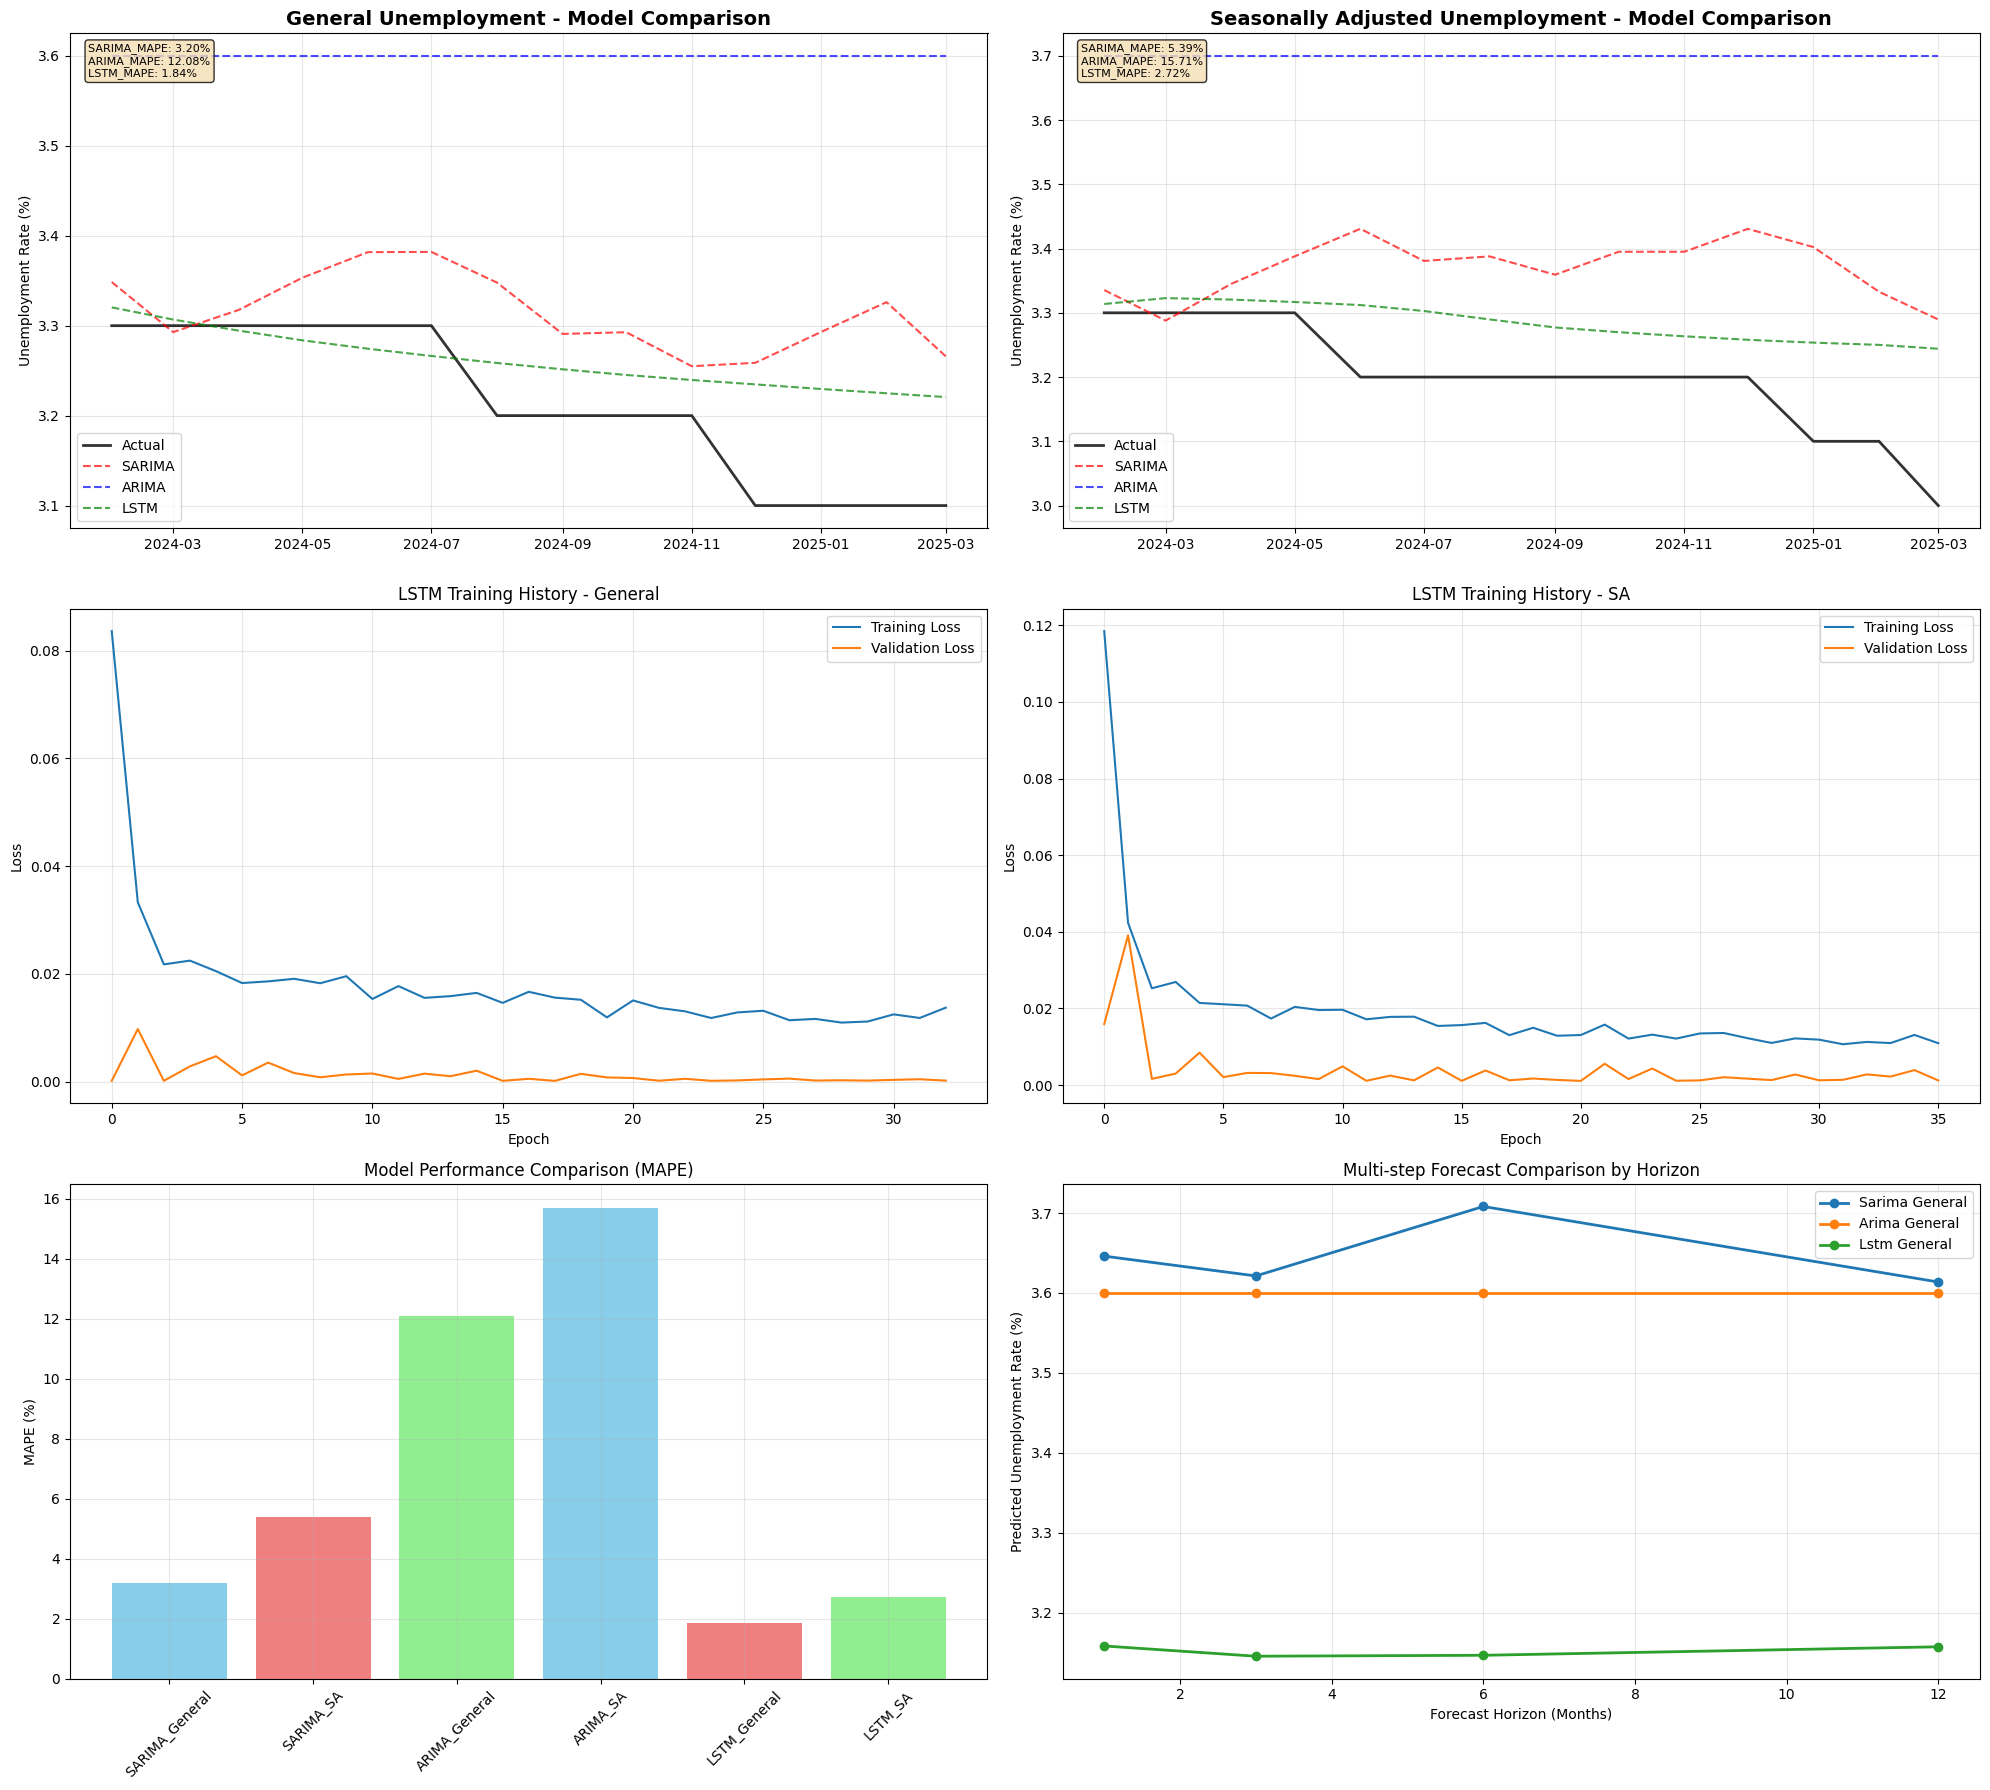

Comprehensive model visualization completed


In [18]:
import matplotlib.pyplot as plt

# Create comprehensive comparison plots
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Helper function to plot model comparisons
def plot_model_comparison(ax, actual_data, forecasts_dict, title, metrics_dict):
    """Plot actual vs predicted for multiple models"""

    # Plot actual data
    ax.plot(actual_data.index, actual_data.values,
           label='Actual', color='black', linewidth=2, alpha=0.8)

    # Plot forecasts
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, (model_name, forecast) in enumerate(forecasts_dict.items()):
        ax.plot(actual_data.index, forecast[:len(actual_data)],
               label=f'{model_name}', color=colors[i % len(colors)],
               linestyle='--', linewidth=1.5, alpha=0.7)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Unemployment Rate (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add metrics text
    metrics_text = '\n'.join([f'{k}: {v:.2f}{"%" if "MAPE" in k else ""}'
                             for k, v in metrics_dict.items()])
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
           verticalalignment='top', bbox=dict(boxstyle='round',
           facecolor='wheat', alpha=0.8), fontsize=8)

# Prepare forecast dictionaries for plotting
forecasts_general = {
    'SARIMA': sarima_test_general.values,
    'ARIMA': arima_test_general,
    'LSTM': lstm_test_general
}

forecasts_sa = {
    'SARIMA': sarima_test_sa.values,
    'ARIMA': arima_test_sa,
    'LSTM': lstm_test_sa
}

# Extract metrics for display
metrics_general = {
    'SARIMA_MAPE': comparison_df[comparison_df['Model'] == 'SARIMA_General']['MAPE'].iloc[0],
    'ARIMA_MAPE': comparison_df[comparison_df['Model'] == 'ARIMA_General']['MAPE'].iloc[0],
    'LSTM_MAPE': comparison_df[comparison_df['Model'] == 'LSTM_General']['MAPE'].iloc[0]
}

metrics_sa = {
    'SARIMA_MAPE': comparison_df[comparison_df['Model'] == 'SARIMA_SA']['MAPE'].iloc[0],
    'ARIMA_MAPE': comparison_df[comparison_df['Model'] == 'ARIMA_SA']['MAPE'].iloc[0],
    'LSTM_MAPE': comparison_df[comparison_df['Model'] == 'LSTM_SA']['MAPE'].iloc[0]
}

# Plotting comparisons
plot_model_comparison(axes[0, 0], test_general, forecasts_general,
                     'General Unemployment - Model Comparison', metrics_general)

plot_model_comparison(axes[0, 1], test_sa, forecasts_sa,
                     'Seasonally Adjusted Unemployment - Model Comparison', metrics_sa)

# Plot training history for LSTM models
axes[1, 0].plot(history_general.history['loss'], label='Training Loss')
if 'val_loss' in history_general.history:
    axes[1, 0].plot(history_general.history['val_loss'], label='Validation Loss')
axes[1, 0].set_title('LSTM Training History - General')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history_sa.history['loss'], label='Training Loss')
if 'val_loss' in history_sa.history:
    axes[1, 1].plot(history_sa.history['val_loss'], label='Validation Loss')
axes[1, 1].set_title('LSTM Training History - SA')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Model performance comparison bar chart
models = comparison_df['Model'].values
mapes = comparison_df['MAPE'].values

axes[2, 0].bar(models, mapes, color=['skyblue', 'lightcoral', 'lightgreen'] * 2)
axes[2, 0].set_title('Model Performance Comparison (MAPE)')
axes[2, 0].set_ylabel('MAPE (%)')
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].grid(True, alpha=0.3)

# Multi-step forecast horizon comparison
horizon_data = []
for horizon in horizons:
    for model in ['sarima_general', 'arima_general', 'lstm_general']:
        horizon_data.append({
            'Horizon': horizon,
            'Model': model.replace('_', ' ').title(),
            'Forecast': forecast_results[horizon][model][-1]
        })

horizon_df = pd.DataFrame(horizon_data)
for model in horizon_df['Model'].unique():
    model_data = horizon_df[horizon_df['Model'] == model]
    axes[2, 1].plot(model_data['Horizon'], model_data['Forecast'],
                   marker='o', label=model, linewidth=2)

axes[2, 1].set_title('Multi-step Forecast Comparison by Horizon')
axes[2, 1].set_xlabel('Forecast Horizon (Months)')
axes[2, 1].set_ylabel('Predicted Unemployment Rate (%)')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Comprehensive model visualization completed")


# 20. Saving to Google Drive

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!cp -R /content/saved_models /content/drive/MyDrive/Employment/